In [1]:
import sys
import logging
from uuid import UUID

import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta

logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)

iphone_ids = [UUID("079e0f1a-c440-3d7c-b0e7-de160f748e35"), UUID("c76a0487-7e5a-3b17-a449-47be666b36f6"), 
              UUID("c528bcd2-a88b-3e82-be62-ef4f2396967a"), UUID("95e70727-a04e-3e33-b7fe-34ab19194f8b")]
android_ids = [UUID("e471711e-bd14-3dbe-80b6-9c7d92ecc296"), UUID("fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7"),
               UUID("86842c35-da28-32ed-a90e-2da6663c5c73"), UUID("3bc0f91f-7660-34a2-b005-5c399598a369")]

In [2]:
list(edb.get_timeseries_db().find({"metadata.key": "config/sensor_config", "data.battery_status": {"$exists": True}}).sort("metadata.write_ts").limit(10))

[]

In [3]:
iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(u), iphone_ids)
android_ts = map(lambda u: esta.TimeSeries.get_time_series(u), android_ids)

In [4]:
iphone_battery_df = map(lambda t:t.get_data_df("background/battery"), iphone_ts)

In [8]:
android_battery_df = map(lambda t:t.get_data_df("background/battery"), android_ts)

In [9]:
first_ios_df = iphone_battery_df[0]

In [16]:
first_ios_df.local_dt.dtype

dtype('<M8[ns]')

In [17]:
first_ios_df[0:2]

,_id,battery_level_pct,battery_status,fmt_time,local_dt,metadata_write_ts,ts
0,56ff6e031268798022721b87,23.0,1,2016-04-02T00:00:18.144429-07:00,2016-04-02 00:00:18.144,1.459580e+09,1.459580e+09
1,56ff7c151268798022721c85,23.0,1,2016-04-02T00:01:25.579024-07:00,2016-04-02 00:01:25.579,1.459580e+09,1.459580e+09


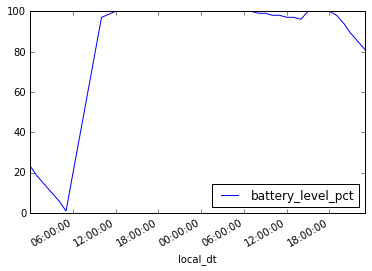

In [18]:
first_ios_df.plot(x='local_dt', y='battery_level_pct')

About to plot 0
About to plot 1
About to plot 2
About to plot 3


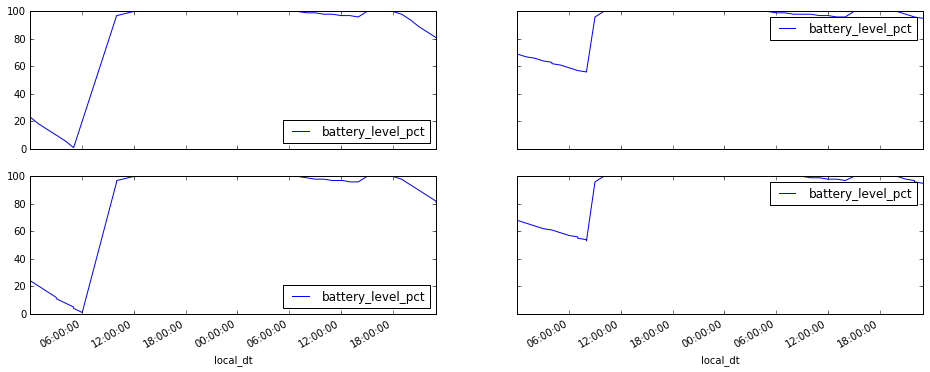

In [19]:
(ifig, iaxes2d) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(16,6))
iaxes = iaxes2d.flatten()
for i, df in enumerate(iphone_battery_df):
    print "About to plot %d" % i
    fixed_df = df[df.battery_level_pct > 0]
    fixed_df.plot(x='local_dt', y='battery_level_pct', ax=iaxes[i])

About to plot 0
About to plot 1
About to plot 2
About to plot 3


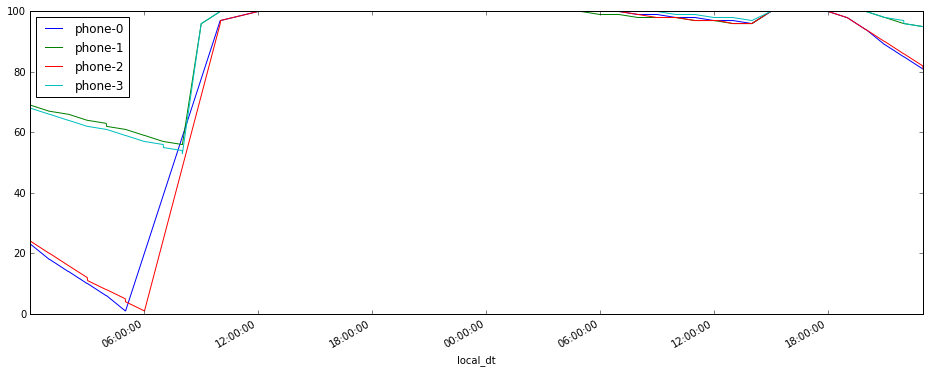

In [20]:
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
for i, df in enumerate(iphone_battery_df):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=iaxes, label="phone-%s" % i)

About to plot 0
About to plot 1
About to plot 2
About to plot 3


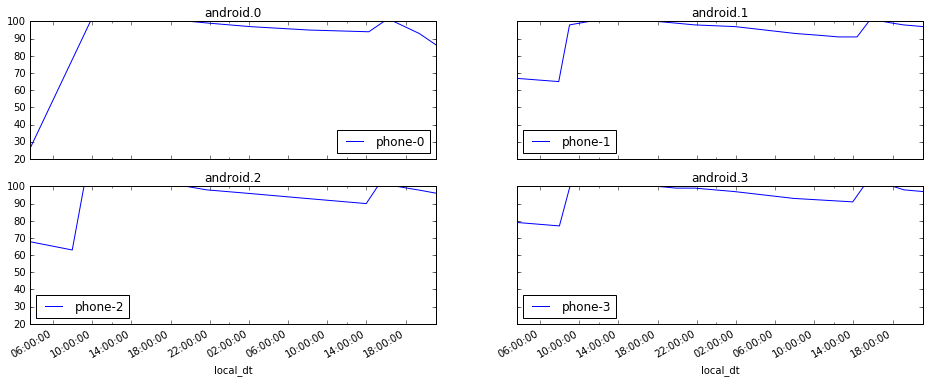

In [21]:
(afig, aaxes2d) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()
for i, df in enumerate(android_battery_df):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=aaxes[i], title="android.%s" % i, label="phone-%s" % i)

About to plot 0
About to plot 1
About to plot 2
About to plot 3


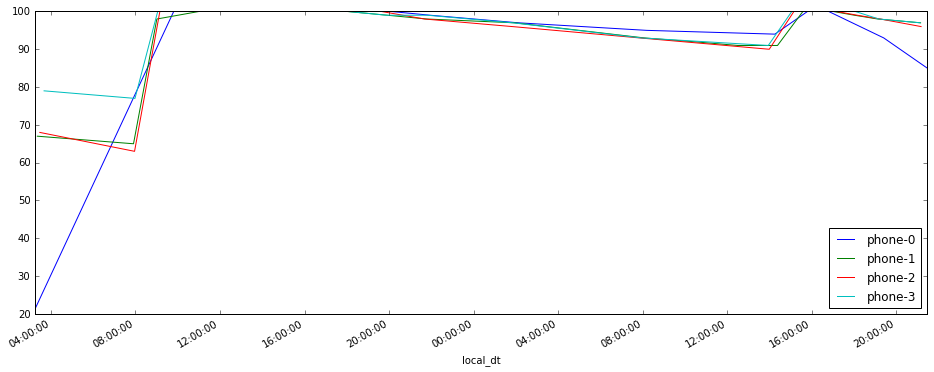

In [22]:
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
aaxes = aaxes2d
for i, df in enumerate(android_battery_df):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=aaxes, label="phone-%s" % i)

In [23]:
def display_drain_over_experiment(iphone_battery_df_list, android_battery_df_list, ranges_df):
    ranges_df['start_local_dt'] = ranges_df.start_ts.apply(pydt.datetime.fromtimestamp)
    ranges_df['end_local_dt'] = ranges_df.end_ts.apply(pydt.datetime.fromtimestamp)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15), sharex=True)
    print "axes = %s with len = %s" % (axes, len(axes))
    ios_ax = axes[0]
    android_ax = axes[1]
    
    ios_ax.set_title("iOS")
    android_ax.set_title("android")
   
    ios_ax.set_ylabel("battery level")
    android_ax.set_ylabel("battery level")

    ios_ax.set_ylim(bottom=0, top=100)
    android_ax.set_ylim(bottom=0, top=100)

    for i, df in enumerate(iphone_battery_df_list):
        print "About to plot iphone %d" % i
        df.plot(x='local_dt', y='battery_level_pct', xlim=(ranges_df.iloc[0].start_local_dt, ranges_df.iloc[-1].end_local_dt), ax=ios_ax, label="phone-%s" % i)

    for i, df in enumerate(android_battery_df_list):
        print "About to plot android %d" % i
        df.plot(x='local_dt', y='battery_level_pct', xlim=(ranges_df.iloc[0].start_local_dt, ranges_df.iloc[-1].end_local_dt), ax=android_ax, label="phone-%s" % i)

    ios_span_map = {}
    android_span_map = {}

    ios_drain_legend = ios_ax.legend(loc=0)
    android_drain_legend = android_ax.legend(loc=0)
    
    for idx, row in ranges_df.iterrows():
        print "adding annotations for %s, %s, %s, %s, %s" % (idx, row.start_local_dt, row.end_local_dt, row.ios_regime, row.android_regime)
        ios_span_map[row.ios_regime] = ios_ax.axvspan(xmin=row.start_local_dt, xmax=row.end_local_dt, 
                                                      color=get_regime_color(row.ios_regime), alpha=0.2, label=row.ios_regime)
        android_span_map[row.android_regime] = android_ax.axvspan(xmin=row.start_local_dt, xmax=row.end_local_dt,
                                                              color=get_regime_color(row.android_regime), alpha=0.2, label=row.android_regime)

    print ios_span_map.keys()

    ios_ax.legend(ios_span_map.values(), ios_span_map.keys(), bbox_to_anchor=(0., +1.1, 1., 1.5), loc=3, mode='expand', ncol=4)
    ios_ax.add_artist(ios_drain_legend)

    android_ax.legend(android_span_map.values(), android_span_map.keys(), bbox_to_anchor=(0., -0.40, 1., 1.5), loc=0, mode='expand', ncol=4)
    android_ax.add_artist(android_drain_legend)
    return (fig, axes)

In [24]:
def get_regime_color(regime):
    if regime == 'high+1sec' or regime == 'best+1m':
        return 'red'
    if regime == 'high-v-balanced+1sec-v-30sec' or regime == 'best-v-10m+1m-v-30m':
        return 'purple'
    if regime == 'high-v-balanced+1sec-v-15sec' or regime == 'best-v-100m+1m-v-30m':
        return 'blue'
    if regime == 'tracking-off':
        return 'black'
    if regime == 'high-vs-balanced-vs-none+1sec-vs-30sec' or regime == 'best-vs-10m-vs-100m-vs-none+1m':
        return 'green'

In [26]:
ranges_df = pd.read_csv("../results_spring_2016/ranges.csv", error_bad_lines=False)

Skipping line 53: expected 7 fields, saw 8



axes = [<matplotlib.axes._subplots.AxesSubplot object at 0x11856f5d0>
 <matplotlib.axes._subplots.AxesSubplot object at 0x11853cd10>] with len = 2
About to plot iphone 0
About to plot iphone 1
About to plot iphone 2
About to plot iphone 3
About to plot android 0
About to plot android 1
About to plot android 2
About to plot android 3
adding annotations for 0, 2016-03-29 12:17:14.700000, 2016-03-29 14:46:54.916000, best+1m, high+1sec
adding annotations for 1, 2016-03-29 14:46:54.916000, 2016-03-29 18:30:30.685000, best+1m, high+1sec
adding annotations for 2, 2016-03-29 18:30:30.685000, 2016-03-29 18:42:30.685000, best+1m, high+1sec
adding annotations for 3, 2016-03-29 18:42:30.685000, 2016-03-29 21:06:30.275000, best+1m, high+1sec
adding annotations for 4, 2016-03-29 21:06:30.275000, 2016-03-30 06:00:09.654000, best+1m, high+1sec
adding annotations for 5, 2016-03-30 06:00:09.654000, 2016-03-30 09:00:13.859000, best+1m, high+1sec
adding annotations for 6, 2016-03-30 09:00:13.859000, 2016-

(<matplotlib.figure.Figure at 0x1184bea10>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11856f5d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11853cd10>], dtype=object))

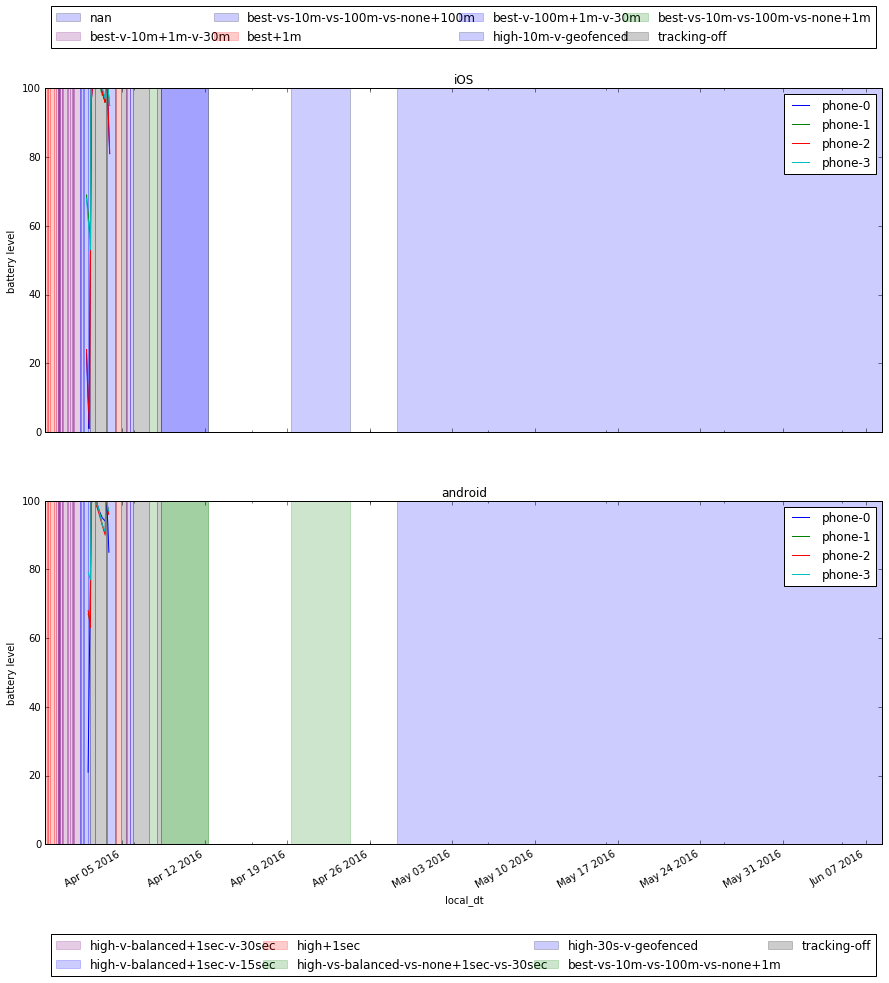

In [27]:
display_drain_over_experiment(iphone_battery_df, android_battery_df, ranges_df)

In [28]:
import scipy.interpolate as spi
import numpy as np

In [29]:
def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    return fn(xnew)

In [30]:
ranges_df

,start_ts,start_fmt_time,end_ts,end_fmt_time,state,android_regime,ios_regime,start_local_dt,end_local_dt
0,1.459279e+09,2016-03-29T12:17:14.700000-07:00,1.459288e+09,2016-03-29T14:46:54.916000-07:00,moving,high+1sec,best+1m,2016-03-29 12:17:14.700,2016-03-29 14:46:54.916
1,1.459288e+09,2016-03-29T14:46:54.916000-07:00,1.459301e+09,2016-03-29T18:30:30.685000-07:00,loitering,high+1sec,best+1m,2016-03-29 14:46:54.916,2016-03-29 18:30:30.685
2,1.459301e+09,2016-03-29T18:30:54.916000-07:00,1.459302e+09,2016-03-29T18:42:30.685000-07:00,moving,high+1sec,best+1m,2016-03-29 18:30:30.685,2016-03-29 18:42:30.685
3,1.459302e+09,2016-03-29T18:42:30.685000-07:00,1.459311e+09,2016-03-29T21:06:30.275000-07:00,moving,high+1sec,best+1m,2016-03-29 18:42:30.685,2016-03-29 21:06:30.275
4,1.459311e+09,2016-03-29T21:06:30.275000-07:00,1.459343e+09,2016-03-30T06:00:09.654643-07:00,stationary,high+1sec,best+1m,2016-03-29 21:06:30.275,2016-03-30 06:00:09.654
5,1.459343e+09,2016-03-30T06:00:09.654643-07:00,1.459354e+09,2016-03-30T09:00:13.859000-07:00,charging-or-full,high+1sec,best+1m,2016-03-30 06:00:09.654,2016-03-30 09:00:13.859
6,1.459354e+09,2016-03-30T09:00:13.859000-07:00,1.459372e+09,2016-03-30T14:01:58.965395-07:00,charging-or-full,high-v-balanced+1sec-v-30sec,best-v-10m+1m-v-30m,2016-03-30 09:00:13.859,2016-03-30 14:01:58.965
7,1.459372e+09,2016-03-30T14:01:58.965395-07:00,1.459372e+09,2016-03-30T14:13:55.019000-07:00,loitering,high-v-balanced+1sec-v-30sec,best-v-10m+1m-v-30m,2016-03-30 14:01:58.965,2016-03-30 14:13:55.019
8,1.459372e+09,2016-03-30T14:13:55.019000-07:00,1.459373e+09,2016-03-30T14:24:42.464000-07:00,moving,high-v-balanced+1sec-v-30sec,best-v-10m+1m-v-30m,2016-03-30 14:13:55.019,2016-03-30 14:24:42.464
9,1.459373e+09,2016-03-30T14:24:42.464000-07:00,1.459376e+09,2016-03-30T15:21:27.670000-07:00,loitering,high-v-balanced+1sec-v-30sec,best-v-10m+1m-v-30m,2016-03-30 14:24:42.464,2016-03-30 15:21:27.670


In [36]:
regime_grouped_ranges_df = ranges_df.groupby(['state', 'android_regime', 'ios_regime'])

In [37]:
#invalid_df = pd.read_csv("../results_spring_2016/invalid.csv")

In [38]:
#invalid_df

In [39]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [46]:
#xnew is the range of ts (15*60 interval) for all data recorded in ranges.cvs
xnew = np.arange(ranges_df.iloc[0].start_ts, ranges_df.iloc[-1].end_ts, 15 * 60) # 30 minutes
#test#
np.arange(0,4,2) #array([0, 2])
np.arange(3) #array([0,1,2])

array([0, 1, 2])

In [22]:
iphone_battery_interp_df = map(lambda df: get_interpolated_df(df, xnew), iphone_battery_df)
android_battery_interp_df = map(lambda df: get_interpolated_df(df, xnew), android_battery_df)

About to plot 0
About to plot 1
About to plot 2
About to plot 3


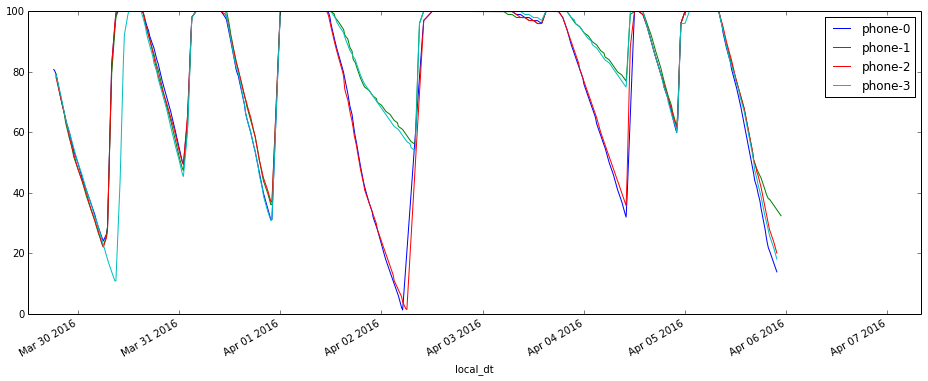

In [23]:
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
for i, df in enumerate(iphone_battery_interp_df):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=iaxes, label="phone-%s" % i)

About to plot 0
About to plot 1
About to plot 2
About to plot 3


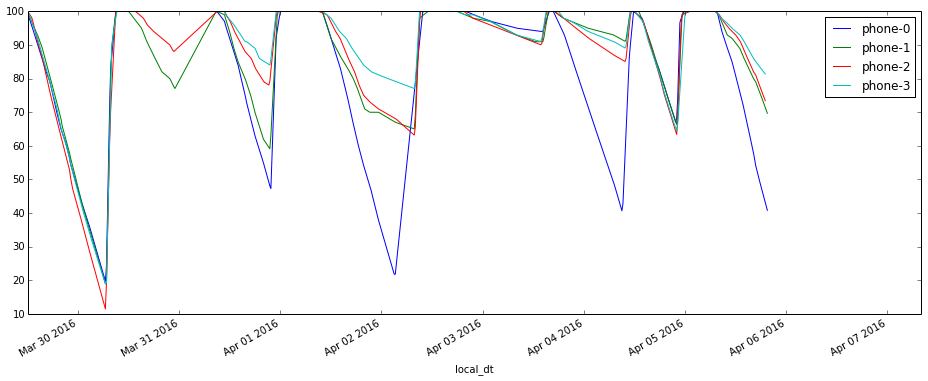

In [24]:
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
aaxes = aaxes2d
for i, df in enumerate(android_battery_interp_df):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=aaxes, label="phone-%s" % i)

In [25]:
def in_invalid_range(ts):
    invalid_result_list = map(lambda row: ts >= row[1].start_ts and ts <= row[1].end_ts, invalid_df.iterrows())
    return reduce(lambda x, y: x or y, invalid_result_list)

In [26]:
filtered_ranges_df = pd.DataFrame(filter(lambda row:not(in_invalid_range(row['start_ts']) or in_invalid_range(row['end_ts'])),
                                         ranges_df.to_dict('records')))

In [27]:
filtered_ranges_df

,android_regime,end_fmt_time,end_ts,ios_regime,start_fmt_time,start_ts,state
0,high+1sec,2016-03-29T14:46:54.916000-07:00,1.459288e+09,best+1m,2016-03-29T12:17:14.700000-07:00,1.459279e+09,moving
1,high+1sec,2016-03-29T18:30:30.685000-07:00,1.459301e+09,best+1m,2016-03-29T14:46:54.916000-07:00,1.459288e+09,loitering
2,high+1sec,2016-03-29T18:42:30.685000-07:00,1.459302e+09,best+1m,2016-03-29T18:30:54.916000-07:00,1.459301e+09,moving
3,high+1sec,2016-03-29T21:06:30.275000-07:00,1.459311e+09,best+1m,2016-03-29T18:42:30.685000-07:00,1.459302e+09,moving
4,high+1sec,2016-03-30T06:00:09.654643-07:00,1.459343e+09,best+1m,2016-03-29T21:06:30.275000-07:00,1.459311e+09,stationary
5,high-v-balanced+1sec-v-30sec,2016-03-31T11:14:15.125000-07:00,1.459448e+09,best-v-10m+1m-v-30m,2016-03-31T09:00:25.839312-07:00,1.459440e+09,loitering
6,high-v-balanced+1sec-v-30sec,2016-03-31T13:32:48.010000-07:00,1.459456e+09,best-v-10m+1m-v-30m,2016-03-31T11:14:15.125000-07:00,1.459448e+09,moving
7,high-v-balanced+1sec-v-30sec,2016-03-31T17:44:00.045000-07:00,1.459471e+09,best-v-10m+1m-v-30m,2016-03-31T13:32:48.010000-07:00,1.459456e+09,loitering
8,high-v-balanced+1sec-v-30sec,2016-03-31T19:57:44.073000-07:00,1.459479e+09,best-v-10m+1m-v-30m,2016-03-31T17:44:00.045000-07:00,1.459471e+09,moving
9,high-v-balanced+1sec-v-30sec,2016-03-31T21:00:37.643000-07:00,1.459483e+09,best-v-10m+1m-v-30m,2016-03-31T19:57:44.073000-07:00,1.459479e+09,stationary


In [28]:
filtered_regime_grouped_ranges_df = filtered_ranges_df.groupby(['state', 'android_regime', 'ios_regime'])

In [29]:
print len(filtered_ranges_df), len(ranges_df)

32 46


In [30]:
def get_combined_df(sensor_df, ranges_df):
    combined_df_parts = map(lambda row: sensor_df[(sensor_df.metadata_write_ts >= row[1].start_ts) & (sensor_df.metadata_write_ts <= row[1].end_ts)],
                                                  ranges_df.iterrows())
    print "lengths are %s" % map(len, combined_df_parts)
    return filter(lambda df: len(df) > 1, combined_df_parts)

In [31]:
def get_combined_df_list(sensor_df_list, ranges_df):
    sensor_ranges_df_list = []
    for df in sensor_df_list:
        sensor_ranges_df_list.append(get_combined_df(df, ranges_df))
    return sensor_ranges_df_list

In [32]:
import matplotlib.dates as mpld

def plot_combined_drain(sensor_df_list, title):
    print "len(sensor_df_list) = %s" % len(sensor_df_list)
    sensor_df_lengths = map(lambda l: len(l), sensor_df_list)
    (fig, axes) = plt.subplots(ncols=max(sensor_df_lengths), nrows=1, sharey=True, figsize=(16,6))
    fig.suptitle(title)
    if max(sensor_df_lengths) == 1:
        axes = [axes]
    for i, phone_df_list in enumerate(sensor_df_list):
        print "About to plot %d plots for phone %d" % (len(phone_df_list), i)
        for j, curr_phone_df in enumerate(phone_df_list):
            axes[j].xaxis.set_major_formatter(mpld.DateFormatter('%h %d %H:%M'))
            curr_phone_df.plot(x='local_dt', y='battery_level_pct', ax=axes[j], ylim=(0,100), label="phone-%s" % i)

### high+1sec and best+1m should be correlated

In [38]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[1] == 'high+1sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(iphone_battery_interp_df, df)
        concat_df_list = map(lambda rl: pd.concat(rl).battery_level_pct, combined_df_list)
        filtered_concat_df_list = map(lambda cdf: cdf[pd.notnull(cdf)], concat_df_list)
        filtered_lengths = map(lambda rl: len(rl), filtered_concat_df_list)
        print "after dropping, lengths are %s" % filtered_lengths
        min_length = min(filtered_lengths)
        if min_length == 0:
            print "One of the phones has no data for this time period, no point in comparing"
        elif min_length != filtered_lengths[0]:
            print "Data does not line up, skipping"
        else:
            print np.corrcoef(filtered_concat_df_list)

For key ('loitering', 'high+1sec', 'best+1m'), ranges_df    android_regime                      end_fmt_time        end_ts ios_regime  \
1       high+1sec  2016-03-29T18:30:30.685000-07:00  1.459301e+09    best+1m   
23      high+1sec        2016-04-04T22:05:02.444129  1.459833e+09    best+1m   

                      start_fmt_time      start_ts      state  
1   2016-03-29T14:46:54.916000-07:00  1.459288e+09  loitering  
23  2016-04-04T12:59:12.753874-07:00  1.459800e+09  loitering   
lengths are [15, 37]
lengths are [15, 37]
lengths are [15, 37]
lengths are [15, 37]
after dropping, lengths are [38, 37, 37, 37]
Data does not line up, skipping
For key ('moving', 'high+1sec', 'best+1m'), ranges_df   android_regime                      end_fmt_time        end_ts ios_regime  \
0      high+1sec  2016-03-29T14:46:54.916000-07:00  1.459288e+09    best+1m   
2      high+1sec  2016-03-29T18:42:30.685000-07:00  1.459302e+09    best+1m   
3      high+1sec  2016-03-29T21:06:30.275000-07:00  1.459

In [39]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[1] == 'high+1sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(android_battery_interp_df, df)
        concat_df_list = map(lambda rl: pd.concat(rl).battery_level_pct, combined_df_list)
        filtered_concat_df_list = map(lambda cdf: cdf[pd.notnull(cdf)], concat_df_list)
        for rl in filtered_concat_df_list:
            print rl.head()
        min_length = min(map(lambda rl: len(rl), filtered_concat_df_list))
        if min_length == 0:
            print "One of the phones has no data for this time period, no point in comparing"
        else:
            print np.corrcoef(filtered_concat_df_list)

For key ('loitering', 'high+1sec', 'best+1m'), ranges_df    android_regime                      end_fmt_time        end_ts ios_regime  \
1       high+1sec  2016-03-29T18:30:30.685000-07:00  1.459301e+09    best+1m   
23      high+1sec        2016-04-04T22:05:02.444129  1.459833e+09    best+1m   

                      start_fmt_time      start_ts      state  
1   2016-03-29T14:46:54.916000-07:00  1.459288e+09  loitering  
23  2016-04-04T12:59:12.753874-07:00  1.459800e+09  loitering   
lengths are [15, 37]
lengths are [15, 37]
lengths are [15, 37]
lengths are [15, 37]
10    88.824201
11    87.809095
12    86.793989
13    85.778883
14    84.763777
Name: battery_level_pct, dtype: float64
10    91.830829
11    90.955937
12    90.081045
13    89.206154
14    88.090537
Name: battery_level_pct, dtype: float64
10    89.551484
11    88.454123
12    87.356762
13    86.259400
14    84.922938
Name: battery_level_pct, dtype: float64
10    90.549260
11    89.444970
12    88.340681
13    87.236392
1

#### What are the overall correlations?

For key ('high+1sec', 'best+1m'), ranges_df    android_regime                      end_fmt_time        end_ts ios_regime  \
0       high+1sec  2016-03-29T14:46:54.916000-07:00  1.459288e+09    best+1m   
1       high+1sec  2016-03-29T18:30:30.685000-07:00  1.459301e+09    best+1m   
2       high+1sec  2016-03-29T18:42:30.685000-07:00  1.459302e+09    best+1m   
3       high+1sec  2016-03-29T21:06:30.275000-07:00  1.459311e+09    best+1m   
4       high+1sec  2016-03-30T06:00:09.654643-07:00  1.459343e+09    best+1m   
23      high+1sec        2016-04-04T22:05:02.444129  1.459833e+09    best+1m   

                      start_fmt_time      start_ts       state  
0   2016-03-29T12:17:14.700000-07:00  1.459279e+09      moving  
1   2016-03-29T14:46:54.916000-07:00  1.459288e+09   loitering  
2   2016-03-29T18:30:54.916000-07:00  1.459301e+09      moving  
3   2016-03-29T18:42:30.685000-07:00  1.459302e+09      moving  
4   2016-03-29T21:06:30.275000-07:00  1.459311e+09  stationary  
23  2

/Users/shankari/OSS/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


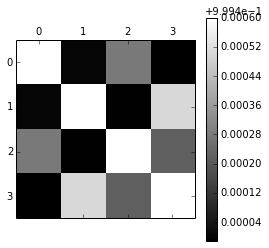

In [40]:
for key, df in filtered_ranges_df.groupby(['android_regime', 'ios_regime']):
    if key[0] == 'high+1sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(iphone_battery_interp_df, df)
        concat_df_list = map(lambda rl: pd.concat(rl).battery_level_pct, combined_df_list)
        
        # filtered_concat_df_list = map(lambda cdf: cdf[pd.notnull(cdf)], concat_df_list)
        # print "After filtering, lengths are %s" % map(lambda rl: len(rl), filtered_concat_df_list)
        min_length = min(map(lambda rl: len(rl), filtered_concat_df_list))
        if min_length == 0:
            print "One of the phones has no data for this time period, no point in comparing"            
        else:
            print np.corrcoef(filtered_concat_df_list)
            plt.matshow(np.corrcoef(filtered_concat_df_list), cmap=plt.cm.gray)
            plt.colorbar()

For key ('high+1sec', 'best+1m'), ranges_df    android_regime                      end_fmt_time        end_ts ios_regime  \
0       high+1sec  2016-03-29T14:46:54.916000-07:00  1.459288e+09    best+1m   
1       high+1sec  2016-03-29T18:30:30.685000-07:00  1.459301e+09    best+1m   
2       high+1sec  2016-03-29T18:42:30.685000-07:00  1.459302e+09    best+1m   
3       high+1sec  2016-03-29T21:06:30.275000-07:00  1.459311e+09    best+1m   
4       high+1sec  2016-03-30T06:00:09.654643-07:00  1.459343e+09    best+1m   
23      high+1sec        2016-04-04T22:05:02.444129  1.459833e+09    best+1m   

                      start_fmt_time      start_ts       state  
0   2016-03-29T12:17:14.700000-07:00  1.459279e+09      moving  
1   2016-03-29T14:46:54.916000-07:00  1.459288e+09   loitering  
2   2016-03-29T18:30:54.916000-07:00  1.459301e+09      moving  
3   2016-03-29T18:42:30.685000-07:00  1.459302e+09      moving  
4   2016-03-29T21:06:30.275000-07:00  1.459311e+09  stationary  
23  2

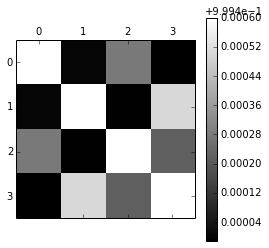

In [41]:
for key, df in filtered_ranges_df.groupby(['android_regime', 'ios_regime']):
    if key[0] == 'high+1sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(android_battery_interp_df, df)
        concat_df_list = map(lambda rl: pd.concat(rl).battery_level_pct, combined_df_list)
        
        # filtered_concat_df_list = map(lambda cdf: cdf[pd.notnull(cdf)], concat_df_list)
        # print "After filtering, lengths are %s" % map(lambda rl: len(rl), filtered_concat_df_list)
        min_length = min(map(lambda rl: len(rl), filtered_concat_df_list))
        if min_length == 0:
            print "One of the phones has no data for this time period, no point in comparing"            
        else:
            print np.corrcoef(filtered_concat_df_list)
            plt.matshow(np.corrcoef(filtered_concat_df_list), cmap=plt.cm.gray)
            plt.colorbar()

#### What about correlations across states?

We can't directly compute correlations across states because:
- we would need to concat data across multiple phones, so there might be jaggedy spikes, and
- since we were at different points at the start, we would have a completely different set of values
- instead, we should compute the drain rate, generate distributions that combine data from multiple phones and check for correlations

## high-v-balanced+1sec-v-15sec,best-v-100m+1m-v-30m should not be correlated

For key ('high-v-balanced+1sec-v-15sec', 'best-v-100m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
12  high-v-balanced+1sec-v-15sec  2016-04-01T11:19:33.655000-07:00   
13  high-v-balanced+1sec-v-15sec  2016-04-01T13:31:02.998000-07:00   
14  high-v-balanced+1sec-v-15sec  2016-04-01T17:48:05.806000-07:00   
15  high-v-balanced+1sec-v-15sec  2016-04-01T19:49:57.554000-07:00   
16  high-v-balanced+1sec-v-15sec  2016-04-02T02:57:37.753000-07:00   
17  high-v-balanced+1sec-v-15sec  2016-04-02T07:57:37.753000-07:00   
21  high-v-balanced+1sec-v-15sec  2016-04-04T10:02:13.321972-07:00   
28  high-v-balanced+1sec-v-15sec  2016-04-05T17:05:31.349801-07:00   
29  high-v-balanced+1sec-v-15sec  2016-04-05T11:10:31.349801-07:00   

          end_ts            ios_regime                    start_fmt_time  \
12  1.459535e+09  best-v-100m+1m-v-30m  2016-04-01T10:05:28.890454-07:00   
13  1.459543e+09  best-v-100m+1m-v-30m  2016-04-01T11:19:33.655000-07:0

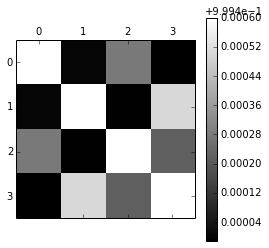

In [42]:
for key, df in filtered_ranges_df.groupby(['android_regime', 'ios_regime']):
    if key[1] == 'best-v-100m+1m-v-30m':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(iphone_battery_interp_df, df)
        concat_df_list = map(lambda rl: pd.concat(rl).battery_level_pct, combined_df_list)
        
        # filtered_concat_df_list = map(lambda cdf: cdf[pd.notnull(cdf)], concat_df_list)
        # print "After filtering, lengths are %s" % map(lambda rl: len(rl), filtered_concat_df_list)
        min_length = min(map(lambda rl: len(rl), filtered_concat_df_list))
        if min_length == 0:
            print "One of the phones has no data for this time period, no point in comparing"            
        else:
            print np.corrcoef(filtered_concat_df_list)
            plt.matshow(np.corrcoef(filtered_concat_df_list), cmap=plt.cm.gray)
            plt.colorbar()

For key ('high-v-balanced+1sec-v-15sec', 'best-v-100m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
12  high-v-balanced+1sec-v-15sec  2016-04-01T11:19:33.655000-07:00   
13  high-v-balanced+1sec-v-15sec  2016-04-01T13:31:02.998000-07:00   
14  high-v-balanced+1sec-v-15sec  2016-04-01T17:48:05.806000-07:00   
15  high-v-balanced+1sec-v-15sec  2016-04-01T19:49:57.554000-07:00   
16  high-v-balanced+1sec-v-15sec  2016-04-02T02:57:37.753000-07:00   
17  high-v-balanced+1sec-v-15sec  2016-04-02T07:57:37.753000-07:00   
21  high-v-balanced+1sec-v-15sec  2016-04-04T10:02:13.321972-07:00   
28  high-v-balanced+1sec-v-15sec  2016-04-05T17:05:31.349801-07:00   
29  high-v-balanced+1sec-v-15sec  2016-04-05T11:10:31.349801-07:00   

          end_ts            ios_regime                    start_fmt_time  \
12  1.459535e+09  best-v-100m+1m-v-30m  2016-04-01T10:05:28.890454-07:00   
13  1.459543e+09  best-v-100m+1m-v-30m  2016-04-01T11:19:33.655000-07:0

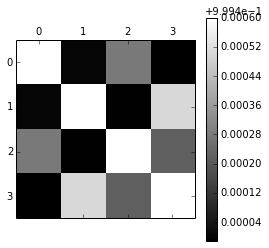

In [43]:
for key, df in filtered_ranges_df.groupby(['android_regime', 'ios_regime']):
    if key[0] == 'high-v-balanced+1sec-v-15sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(android_battery_interp_df, df)
        concat_df_list = map(lambda rl: pd.concat(rl).battery_level_pct, combined_df_list)
        
        # filtered_concat_df_list = map(lambda cdf: cdf[pd.notnull(cdf)], concat_df_list)
        # print "After filtering, lengths are %s" % map(lambda rl: len(rl), filtered_concat_df_list)
        min_length = min(map(lambda rl: len(rl), filtered_concat_df_list))
        if min_length == 0:
            print "One of the phones has no data for this time period, no point in comparing"            
        else:
            print np.corrcoef(filtered_concat_df_list)
            plt.matshow(np.corrcoef(filtered_concat_df_list), cmap=plt.cm.gray)
            plt.colorbar()

In [44]:
pd.Panel({'a': pd.DataFrame({'b': [1,2,3], 'c': [4,5,6]})})

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 3 (major_axis) x 2 (minor_axis)
Items axis: a to a
Major_axis axis: 0 to 2
Minor_axis axis: b to c

## Compute rates instead

For key ('loitering', 'high+1sec', 'best+1m'), ranges_df    android_regime                      end_fmt_time        end_ts ios_regime  \
1       high+1sec  2016-03-29T18:30:30.685000-07:00  1.459301e+09    best+1m   
23      high+1sec        2016-04-04T22:05:02.444129  1.459833e+09    best+1m   

                      start_fmt_time      start_ts      state  
1   2016-03-29T14:46:54.916000-07:00  1.459288e+09  loitering  
23  2016-04-04T12:59:12.753874-07:00  1.459800e+09  loitering   
lengths are [15, 37]
lengths are [15, 37]
lengths are [15, 37]
lengths are [15, 37]
For key ('moving', 'high+1sec', 'best+1m'), ranges_df   android_regime                      end_fmt_time        end_ts ios_regime  \
0      high+1sec  2016-03-29T14:46:54.916000-07:00  1.459288e+09    best+1m   
2      high+1sec  2016-03-29T18:42:30.685000-07:00  1.459302e+09    best+1m   
3      high+1sec  2016-03-29T21:06:30.275000-07:00  1.459311e+09    best+1m   

                     start_fmt_time      start_ts   st

-c:21: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


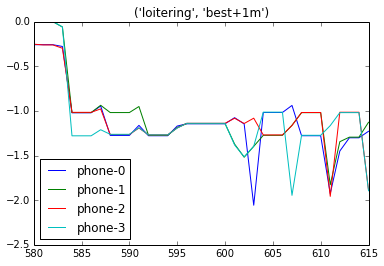

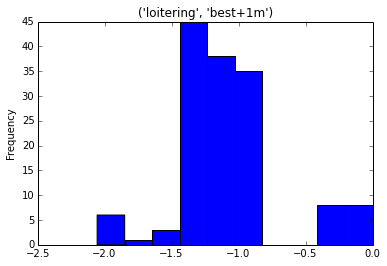

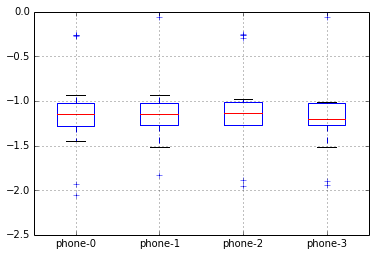

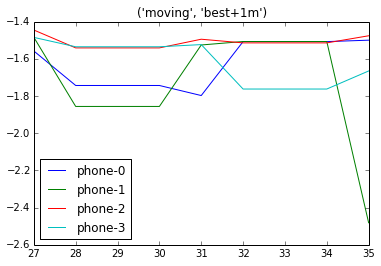

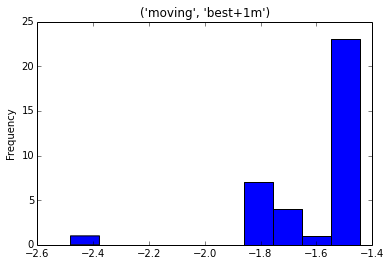

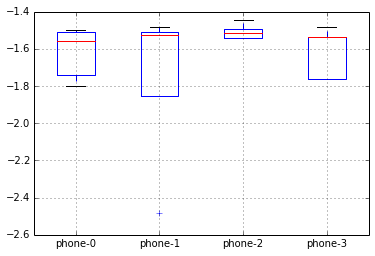

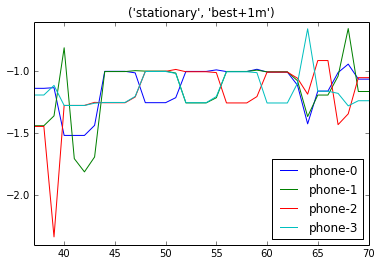

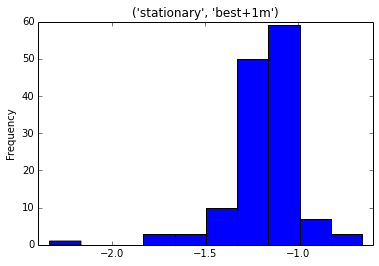

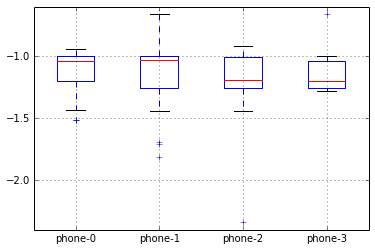

In [45]:
ios_high_rates = {}
for key, df in filtered_regime_grouped_ranges_df:
    if key[1] == 'high+1sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(iphone_battery_interp_df, df)
        drain_series_list = map(lambda rl: map(lambda df: df.battery_level_pct.diff(), rl), combined_df_list)
        concat_df_list = map(lambda rl: pd.concat(rl), drain_series_list)
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
        
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        filtered_df = concat_df_curr_regime.dropna()
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

For key ('loitering', 'high+1sec', 'best+1m'), ranges_df    android_regime                      end_fmt_time        end_ts ios_regime  \
1       high+1sec  2016-03-29T18:30:30.685000-07:00  1.459301e+09    best+1m   
23      high+1sec        2016-04-04T22:05:02.444129  1.459833e+09    best+1m   

                      start_fmt_time      start_ts      state  
1   2016-03-29T14:46:54.916000-07:00  1.459288e+09  loitering  
23  2016-04-04T12:59:12.753874-07:00  1.459800e+09  loitering   
lengths are [15, 37]
lengths are [15, 37]
lengths are [15, 37]
lengths are [15, 37]
For key ('moving', 'high+1sec', 'best+1m'), ranges_df   android_regime                      end_fmt_time        end_ts ios_regime  \
0      high+1sec  2016-03-29T14:46:54.916000-07:00  1.459288e+09    best+1m   
2      high+1sec  2016-03-29T18:42:30.685000-07:00  1.459302e+09    best+1m   
3      high+1sec  2016-03-29T21:06:30.275000-07:00  1.459311e+09    best+1m   

                     start_fmt_time      start_ts   st

-c:23: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


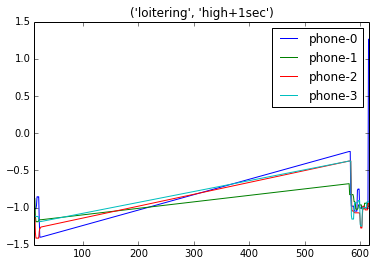

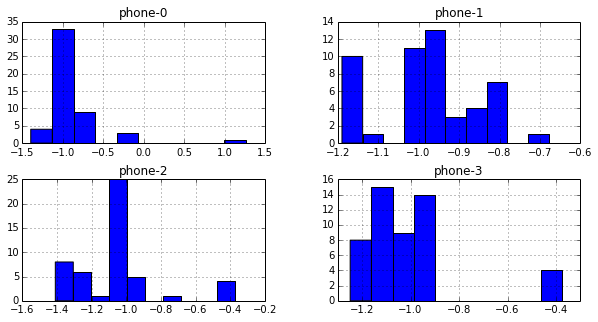

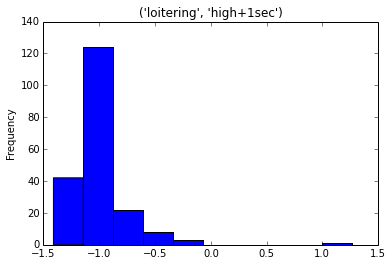

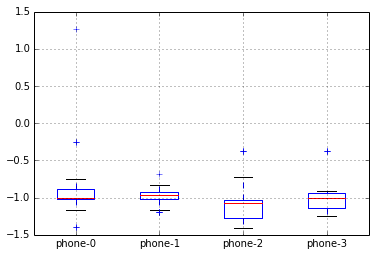

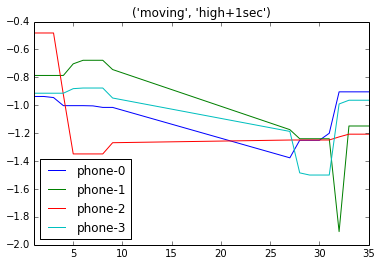

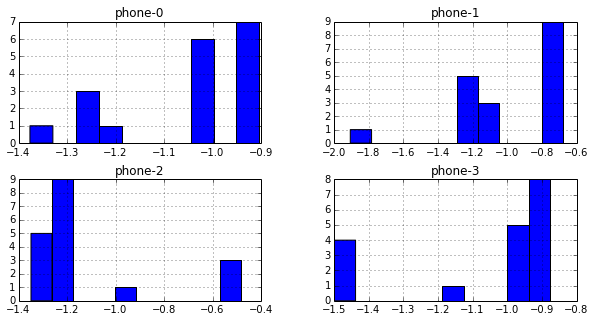

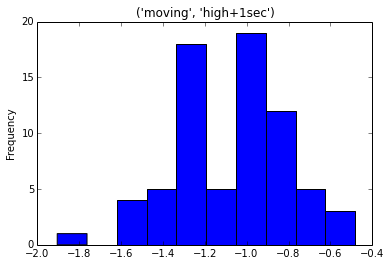

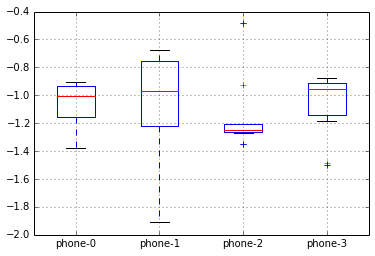

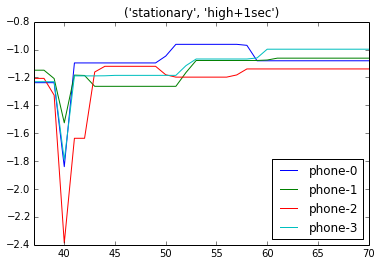

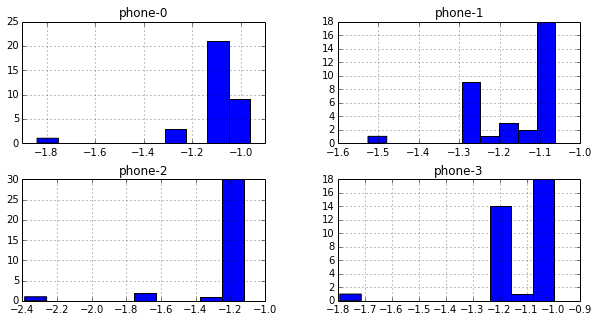

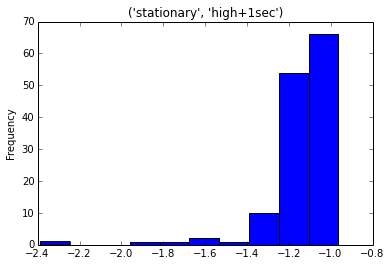

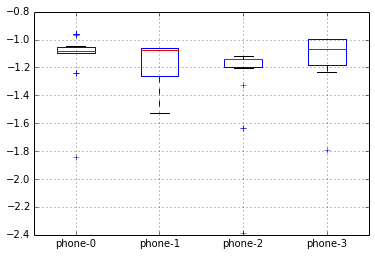

In [46]:
android_high_rates = {}
for key, df in filtered_regime_grouped_ranges_df:
    if key[1] == 'high+1sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(android_battery_interp_df, df)
        drain_series_list = map(lambda rl: map(lambda df: df.battery_level_pct.diff(), rl), combined_df_list)
        concat_df_list = map(lambda rl: pd.concat(rl), drain_series_list)
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
        
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        filtered_df = concat_df_curr_regime.dropna()
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        android_high_rates[key[0]] = all_phones_curr_regime_series
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[1]))
            plt.figure()
            filtered_df.hist(figsize=(10,5))
            plt.figure()
            all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[1]))
            plt.figure()
            concat_df_curr_regime.boxplot()

For key ('loitering', 'high-v-balanced+1sec-v-15sec', 'best-v-100m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
14  high-v-balanced+1sec-v-15sec  2016-04-01T17:48:05.806000-07:00   

          end_ts            ios_regime                    start_fmt_time  \
14  1.459558e+09  best-v-100m+1m-v-30m  2016-04-01T13:14:35.602000-07:00   

        start_ts      state  
14  1.459542e+09  loitering   
lengths are [19]
lengths are [19]
lengths are [19]
lengths are [19]
For key ('moving', 'high-v-balanced+1sec-v-15sec', 'best-v-100m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
13  high-v-balanced+1sec-v-15sec  2016-04-01T13:31:02.998000-07:00   
15  high-v-balanced+1sec-v-15sec  2016-04-01T19:49:57.554000-07:00   

          end_ts            ios_regime                    start_fmt_time  \
13  1.459543e+09  best-v-100m+1m-v-30m  2016-04-01T11:19:33.655000-07:00   
15  1.459565e+09  best-v-100m+1m-v-30m 

-c:22: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


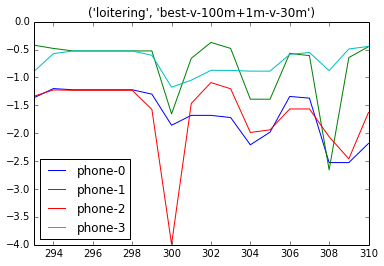

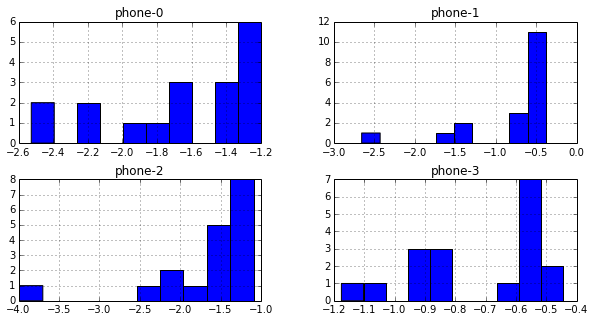

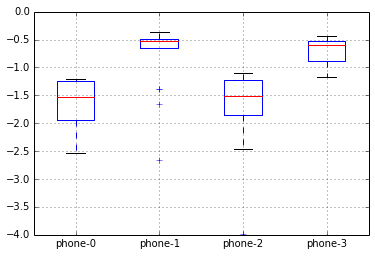

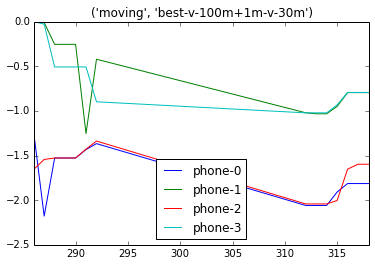

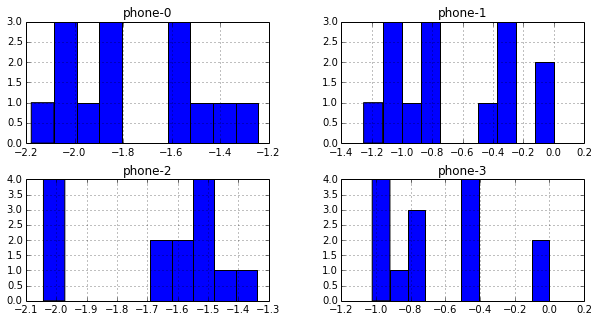

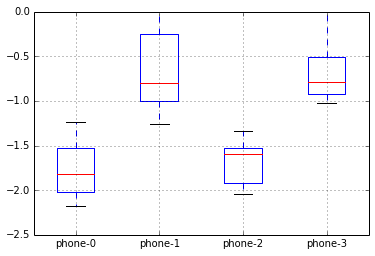

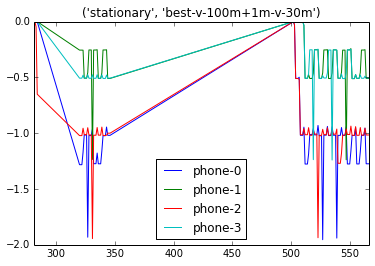

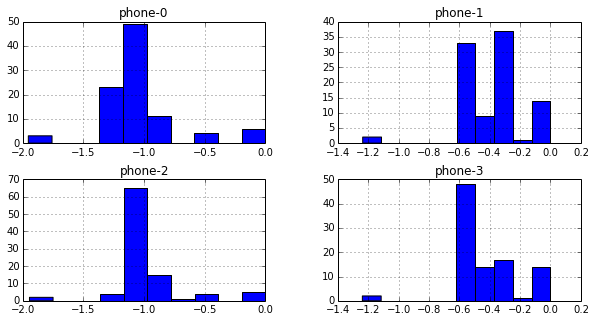

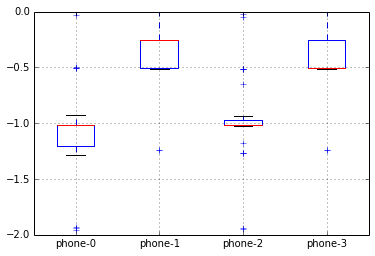

In [47]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[0] != 'invalid' and key[2] == 'best-v-100m+1m-v-30m':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(iphone_battery_interp_df, df)
        drain_series_list = map(lambda rl: map(lambda df: df.battery_level_pct.diff(), rl), combined_df_list)
        concat_df_list = map(lambda rl: pd.concat(rl), drain_series_list)
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
        
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        filtered_df = concat_df_curr_regime.dropna()
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            filtered_df.hist(figsize=(10,5))
            # plt.figure()
            # all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

For key ('loitering', 'high-v-balanced+1sec-v-15sec', 'best-v-100m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
14  high-v-balanced+1sec-v-15sec  2016-04-01T17:48:05.806000-07:00   

          end_ts            ios_regime                    start_fmt_time  \
14  1.459558e+09  best-v-100m+1m-v-30m  2016-04-01T13:14:35.602000-07:00   

        start_ts      state  
14  1.459542e+09  loitering   
lengths are [19]
lengths are [19]
lengths are [19]
lengths are [19]
For key ('moving', 'high-v-balanced+1sec-v-15sec', 'best-v-100m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
13  high-v-balanced+1sec-v-15sec  2016-04-01T13:31:02.998000-07:00   
15  high-v-balanced+1sec-v-15sec  2016-04-01T19:49:57.554000-07:00   

          end_ts            ios_regime                    start_fmt_time  \
13  1.459543e+09  best-v-100m+1m-v-30m  2016-04-01T11:19:33.655000-07:00   
15  1.459565e+09  best-v-100m+1m-v-30m 

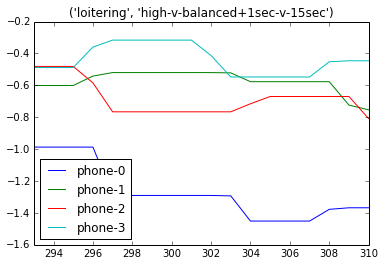

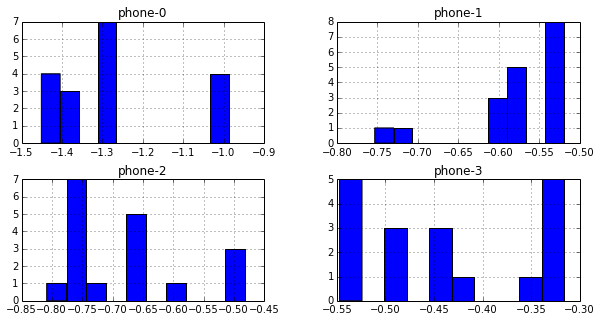

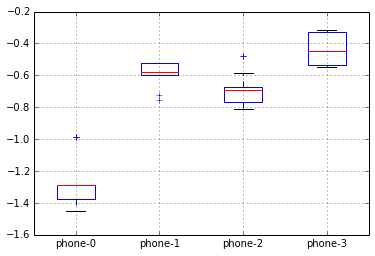

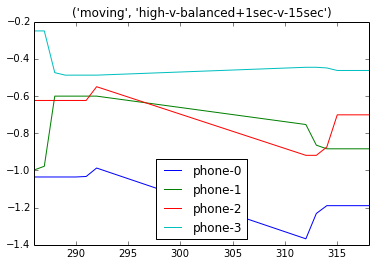

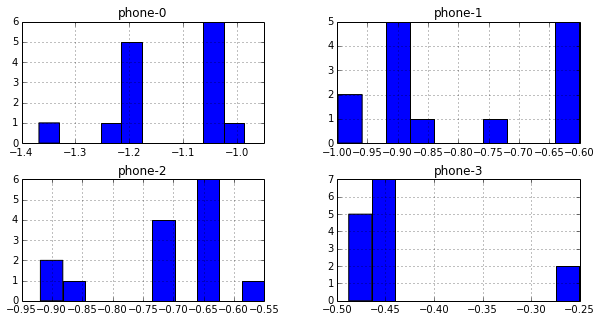

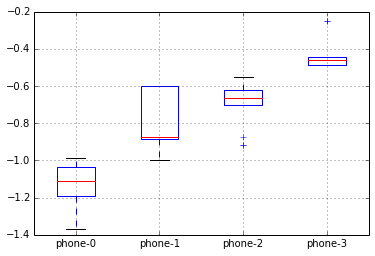

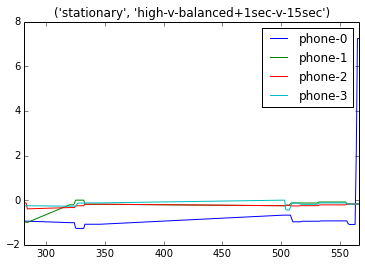

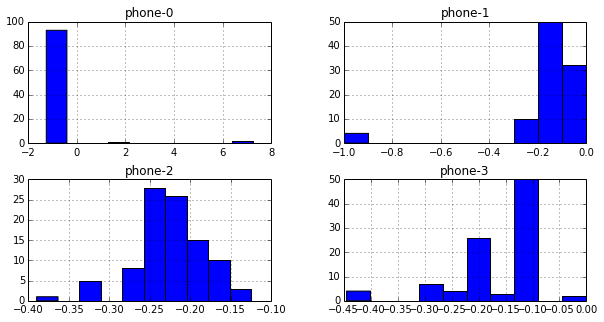

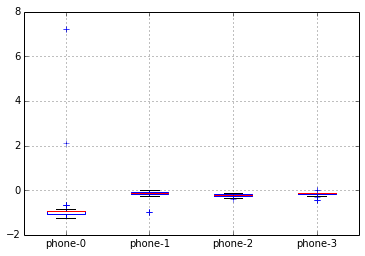

In [48]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[0] != 'invalid' and key[1] == 'high-v-balanced+1sec-v-15sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(android_battery_interp_df, df)
        drain_series_list = map(lambda rl: map(lambda df: df.battery_level_pct.diff(), rl), combined_df_list)
        concat_df_list = map(lambda rl: pd.concat(rl), drain_series_list)
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
        
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        filtered_df = concat_df_curr_regime.dropna()
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[1]))
            fig = plt.figure()
            fig.suptitle((key[0], key[1]))
            filtered_df.hist(figsize=(10,5))
            # plt.figure()
            # all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

For key ('loitering', 'high-v-balanced+1sec-v-30sec', 'best-v-10m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
5   high-v-balanced+1sec-v-30sec  2016-03-31T11:14:15.125000-07:00   
7   high-v-balanced+1sec-v-30sec  2016-03-31T17:44:00.045000-07:00   
27  high-v-balanced+1sec-v-30sec  2016-04-05T16:50:31.349801-07:00   

          end_ts           ios_regime                    start_fmt_time  \
5   1.459448e+09  best-v-10m+1m-v-30m  2016-03-31T09:00:25.839312-07:00   
7   1.459471e+09  best-v-10m+1m-v-30m  2016-03-31T13:32:48.010000-07:00   
27  1.459900e+09  best-v-10m+1m-v-30m  2016-04-05T09:48:39.276000-07:00   

        start_ts      state  
5   1.459440e+09  loitering  
7   1.459456e+09  loitering  
27  1.459875e+09  loitering   
lengths are [9, 16, 28]
lengths are [9, 16, 28]
lengths are [9, 16, 28]
lengths are [9, 16, 28]
For key ('moving', 'high-v-balanced+1sec-v-30sec', 'best-v-10m+1m-v-30m'), ranges_df                   android_re

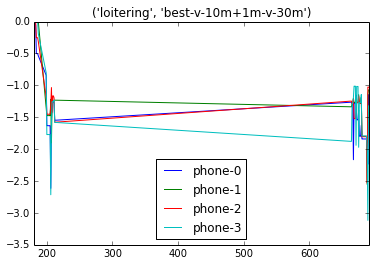

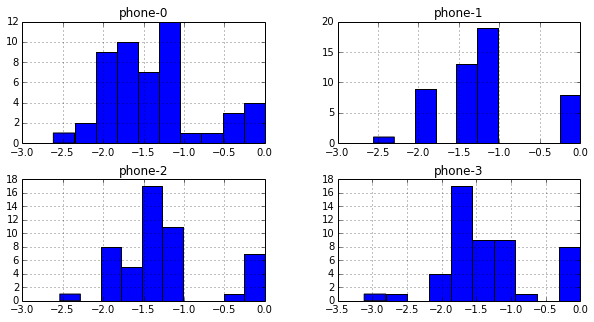

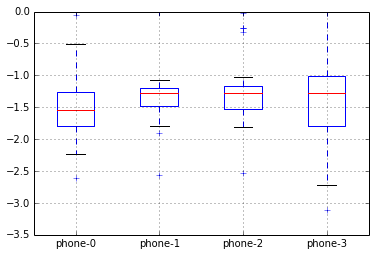

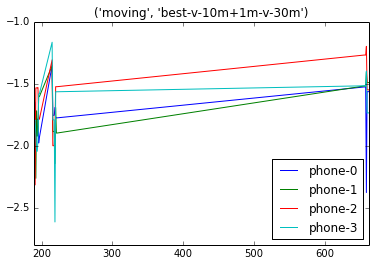

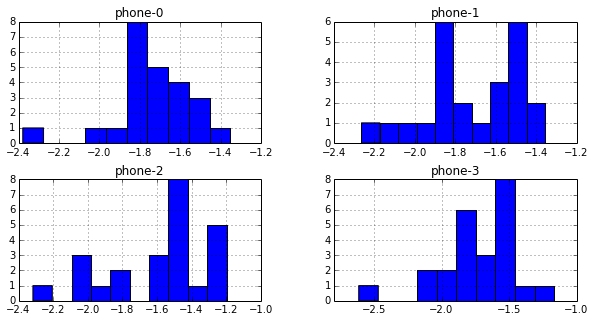

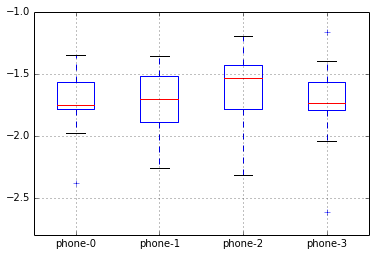

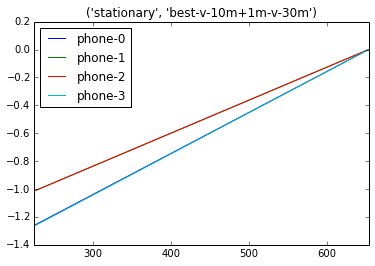

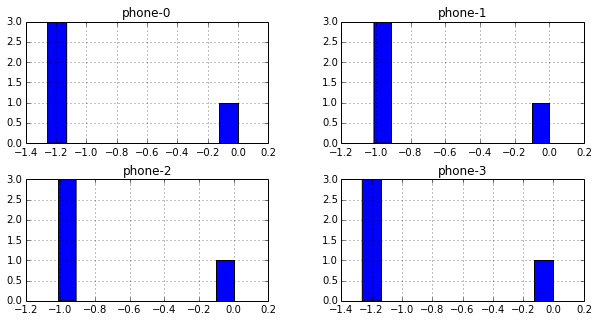

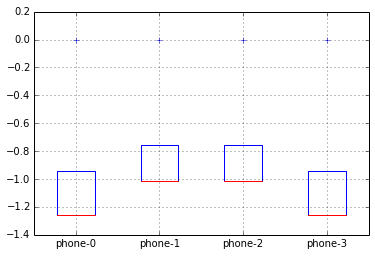

In [49]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[0] != 'invalid' and key[0] != 'charging-or-full' and key[2] == 'best-v-10m+1m-v-30m':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(iphone_battery_interp_df, df)
        drain_series_list = map(lambda rl: map(lambda df: df.battery_level_pct.diff(), rl), combined_df_list)
        concat_df_list = map(lambda rl: pd.concat(rl), drain_series_list)
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
        
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        filtered_df = concat_df_curr_regime.dropna()
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            filtered_df.hist(figsize=(10,5))
            # plt.figure()
            # all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

For key ('loitering', 'high-v-balanced+1sec-v-30sec', 'best-v-10m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
5   high-v-balanced+1sec-v-30sec  2016-03-31T11:14:15.125000-07:00   
7   high-v-balanced+1sec-v-30sec  2016-03-31T17:44:00.045000-07:00   
27  high-v-balanced+1sec-v-30sec  2016-04-05T16:50:31.349801-07:00   

          end_ts           ios_regime                    start_fmt_time  \
5   1.459448e+09  best-v-10m+1m-v-30m  2016-03-31T09:00:25.839312-07:00   
7   1.459471e+09  best-v-10m+1m-v-30m  2016-03-31T13:32:48.010000-07:00   
27  1.459900e+09  best-v-10m+1m-v-30m  2016-04-05T09:48:39.276000-07:00   

        start_ts      state  
5   1.459440e+09  loitering  
7   1.459456e+09  loitering  
27  1.459875e+09  loitering   
lengths are [9, 16, 28]
lengths are [9, 16, 28]
lengths are [9, 16, 28]
lengths are [9, 16, 28]
For key ('moving', 'high-v-balanced+1sec-v-30sec', 'best-v-10m+1m-v-30m'), ranges_df                   android_re

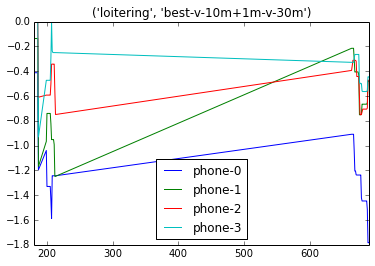

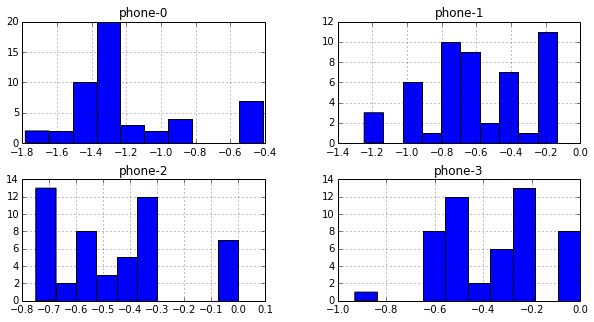

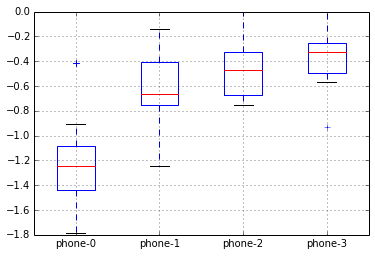

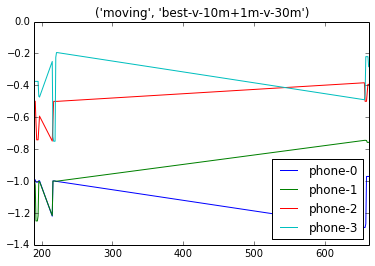

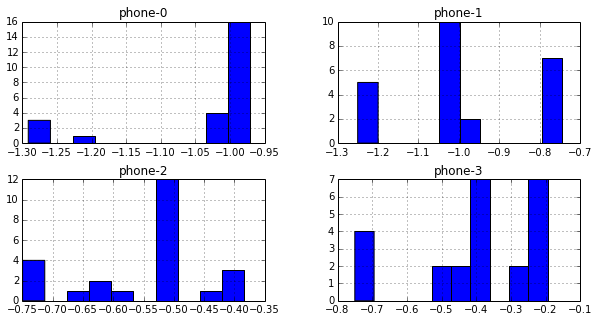

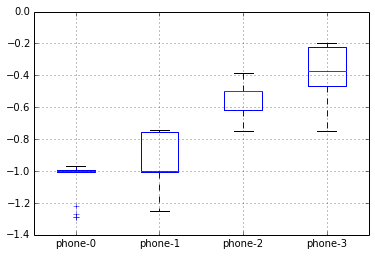

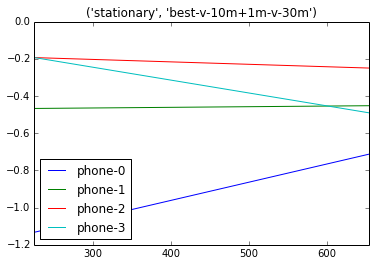

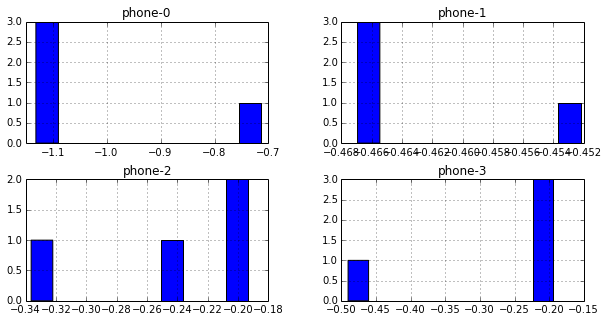

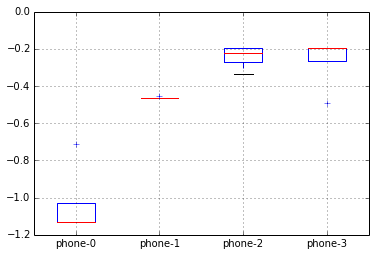

In [50]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[0] != 'invalid' and key[0] != 'charging-or-full' and key[1] == 'high-v-balanced+1sec-v-30sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(android_battery_interp_df, df)
        drain_series_list = map(lambda rl: map(lambda df: df.battery_level_pct.diff(), rl), combined_df_list)
        concat_df_list = map(lambda rl: pd.concat(rl), drain_series_list)
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
         
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        filtered_df = concat_df_curr_regime.dropna()
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            filtered_df.hist(figsize=(10,5))
            # plt.figure()
            # all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

## Check the frequency of updates

For key ('loitering', 'high+1sec', 'best+1m'), ranges_df    android_regime                      end_fmt_time        end_ts ios_regime  \
1       high+1sec  2016-03-29T18:30:30.685000-07:00  1.459301e+09    best+1m   
23      high+1sec        2016-04-04T22:05:02.444129  1.459833e+09    best+1m   

                      start_fmt_time      start_ts      state  
1   2016-03-29T14:46:54.916000-07:00  1.459288e+09  loitering  
23  2016-04-04T12:59:12.753874-07:00  1.459800e+09  loitering   
lengths are [2, 23]
lengths are [0, 23]
lengths are [0, 23]
lengths are [0, 23]
For key ('moving', 'high+1sec', 'best+1m'), ranges_df   android_regime                      end_fmt_time        end_ts ios_regime  \
0      high+1sec  2016-03-29T14:46:54.916000-07:00  1.459288e+09    best+1m   
2      high+1sec  2016-03-29T18:42:30.685000-07:00  1.459302e+09    best+1m   
3      high+1sec  2016-03-29T21:06:30.275000-07:00  1.459311e+09    best+1m   

                     start_fmt_time      start_ts   state 

-c:24: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


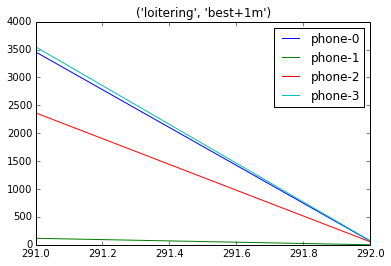

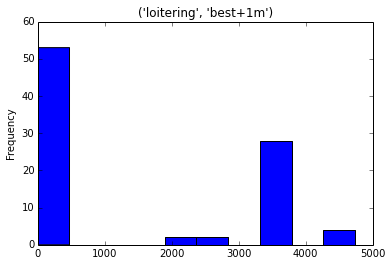

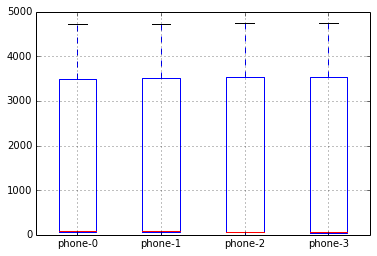

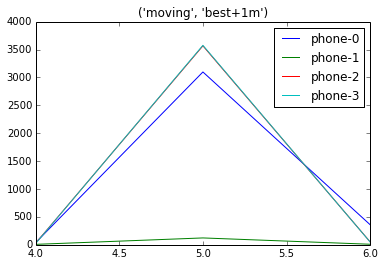

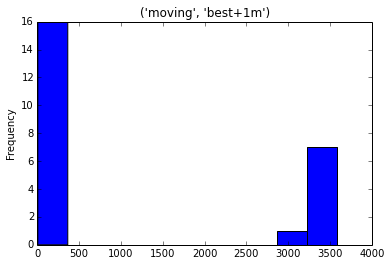

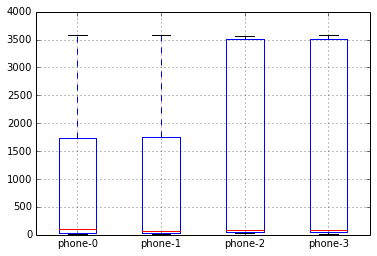

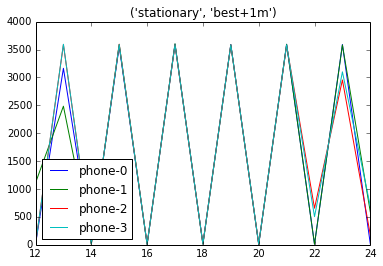

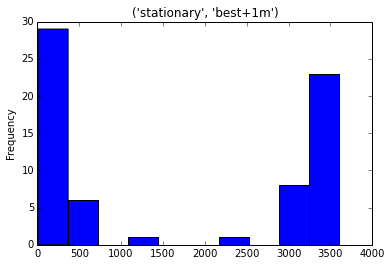

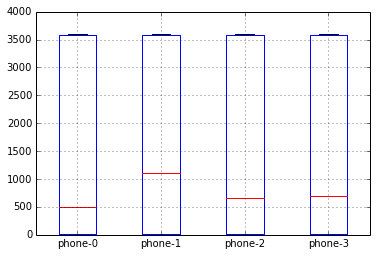

In [51]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[1] == 'high+1sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(iphone_battery_df, df)
        time_diff_series_list = map(lambda rl: map(lambda df: df.ts.diff(), rl), combined_df_list)
        try:
            concat_df_list = map(lambda rl: pd.concat(rl), time_diff_series_list)
        except ValueError, e:
            print "No data to concatenate, skipping"
            continue
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
        
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        filtered_df = concat_df_curr_regime.dropna()
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

/Users/shankari/OSS/anaconda/lib/python2.7/site-packages/matplotlib/axes.py:2536: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=4.0, right=4.0
  + 'left=%s, right=%s') % (left, right))
-c:20: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


For key ('loitering', 'high+1sec', 'best+1m'), ranges_df    android_regime                      end_fmt_time        end_ts ios_regime  \
1       high+1sec  2016-03-29T18:30:30.685000-07:00  1.459301e+09    best+1m   
23      high+1sec        2016-04-04T22:05:02.444129  1.459833e+09    best+1m   

                      start_fmt_time      start_ts      state  
1   2016-03-29T14:46:54.916000-07:00  1.459288e+09  loitering  
23  2016-04-04T12:59:12.753874-07:00  1.459800e+09  loitering   
lengths are [2, 8]
lengths are [2, 7]
lengths are [3, 7]
lengths are [2, 7]
For key ('moving', 'high+1sec', 'best+1m'), ranges_df   android_regime                      end_fmt_time        end_ts ios_regime  \
0      high+1sec  2016-03-29T14:46:54.916000-07:00  1.459288e+09    best+1m   
2      high+1sec  2016-03-29T18:42:30.685000-07:00  1.459302e+09    best+1m   
3      high+1sec  2016-03-29T21:06:30.275000-07:00  1.459311e+09    best+1m   

                     start_fmt_time      start_ts   state  
0 

/Users/shankari/OSS/anaconda/lib/python2.7/site-packages/matplotlib/axes.py:2536: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=11.0, right=11.0
  + 'left=%s, right=%s') % (left, right))


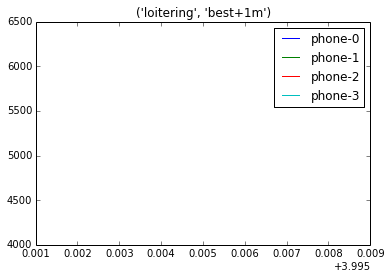

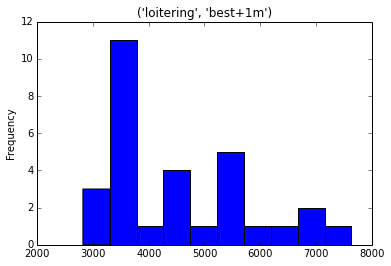

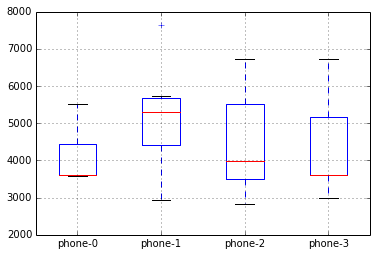

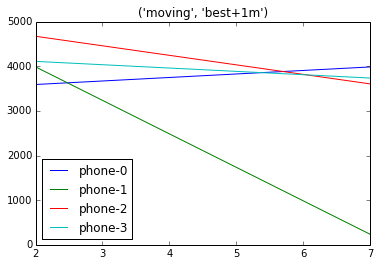

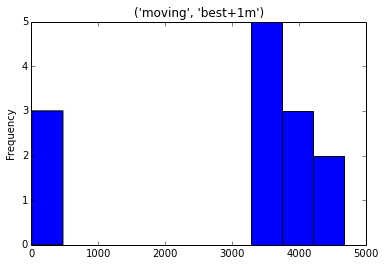

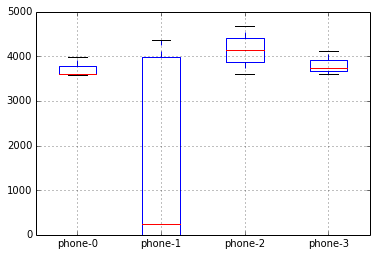

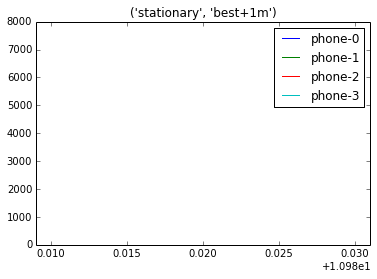

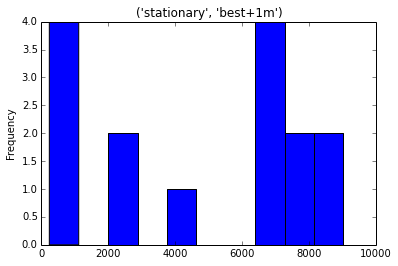

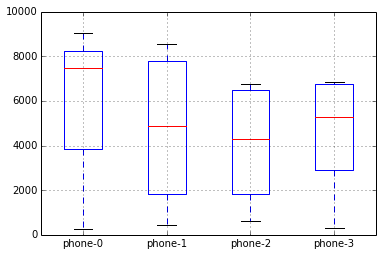

In [52]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[1] == 'high+1sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(android_battery_df, df)
        time_diff_series_list = map(lambda rl: map(lambda df: df.ts.diff(), rl), combined_df_list)
        concat_df_list = map(lambda rl: pd.concat(rl), time_diff_series_list)
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
        
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        filtered_df = concat_df_curr_regime.dropna()
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

For key ('invalid', 'high-v-balanced+1sec-v-15sec', 'best-v-100m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
17  high-v-balanced+1sec-v-15sec  2016-04-02T07:57:37.753000-07:00   
28  high-v-balanced+1sec-v-15sec  2016-04-05T17:05:31.349801-07:00   
29  high-v-balanced+1sec-v-15sec  2016-04-05T11:10:31.349801-07:00   

          end_ts            ios_regime                    start_fmt_time  \
17  1.459609e+09  best-v-100m+1m-v-30m  2016-04-02T02:57:37.753000-07:00   
28  1.459901e+09  best-v-100m+1m-v-30m  2016-04-05T16:50:31.349801-07:00   
29  1.459880e+09  best-v-100m+1m-v-30m  2016-04-05T17:05:31.349801-07:00   

        start_ts    state  
17  1.459591e+09  invalid  
28  1.459900e+09  invalid  
29  1.459901e+09  invalid   
lengths are [6, 2, 0]
lengths are [10, 2, 0]
lengths are [8, 2, 0]
lengths are [10, 2, 0]
     phone-0   phone-1   phone-2   phone-3
8        NaN       NaN       NaN       NaN
9    248.024       NaN   638.489   308

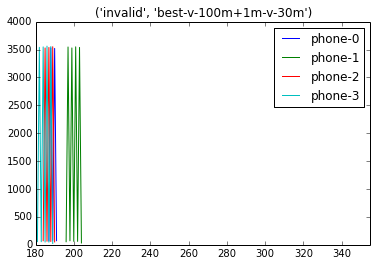

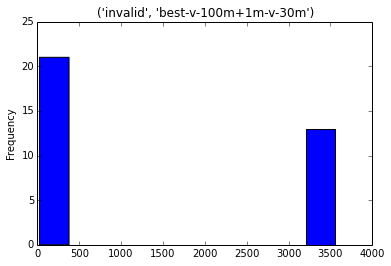

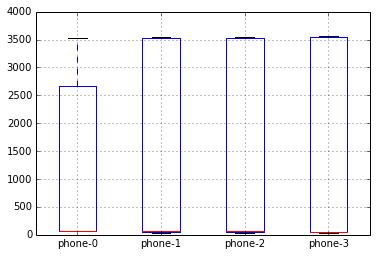

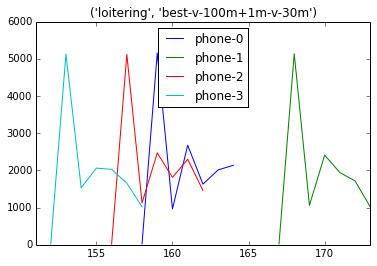

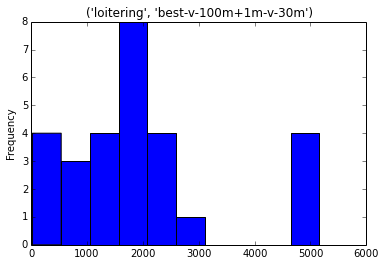

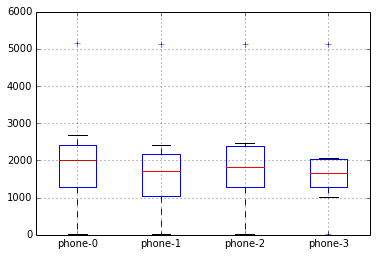

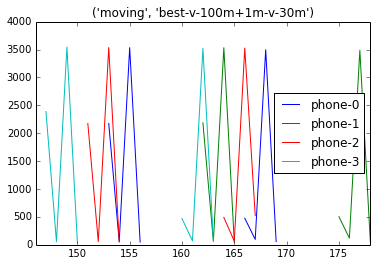

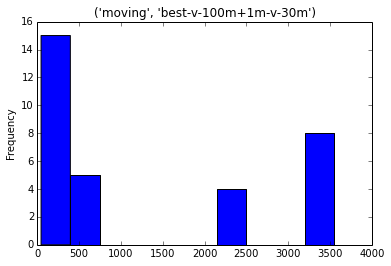

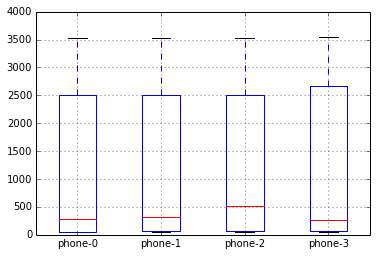

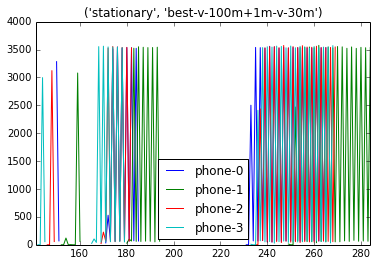

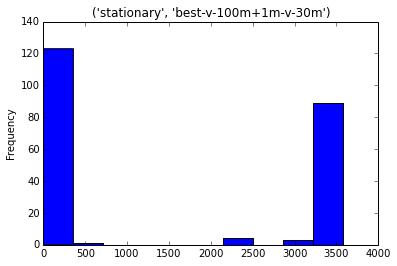

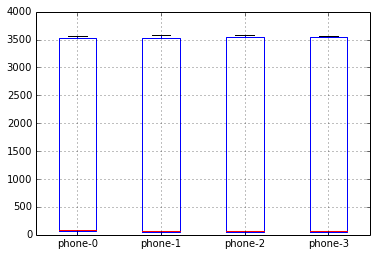

In [53]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[2] == 'best-v-100m+1m-v-30m':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(iphone_battery_df, df)
        time_diff_series_list = map(lambda rl: map(lambda df: df.ts.diff(), rl), combined_df_list)
        concat_df_list = map(lambda rl: pd.concat(rl), time_diff_series_list)
        
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
            
        print concat_df_curr_regime
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        # filtered_df = concat_df_curr_regime.dropna()
        filtered_df = concat_df_curr_regime
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        print "after filtering, length = %s" % len(filtered_df)
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

For key ('invalid', 'high-v-balanced+1sec-v-15sec', 'best-v-100m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
17  high-v-balanced+1sec-v-15sec  2016-04-02T07:57:37.753000-07:00   
28  high-v-balanced+1sec-v-15sec  2016-04-05T17:05:31.349801-07:00   
29  high-v-balanced+1sec-v-15sec  2016-04-05T11:10:31.349801-07:00   

          end_ts            ios_regime                    start_fmt_time  \
17  1.459609e+09  best-v-100m+1m-v-30m  2016-04-02T02:57:37.753000-07:00   
28  1.459901e+09  best-v-100m+1m-v-30m  2016-04-05T16:50:31.349801-07:00   
29  1.459880e+09  best-v-100m+1m-v-30m  2016-04-05T17:05:31.349801-07:00   

        start_ts    state  
17  1.459591e+09  invalid  
28  1.459900e+09  invalid  
29  1.459901e+09  invalid   
lengths are [1, 0, 0]
lengths are [2, 0, 0]
lengths are [2, 0, 0]
lengths are [1, 0, 0]
No data to concatenate, skipping
For key ('loitering', 'high-v-balanced+1sec-v-15sec', 'best-v-100m+1m-v-30m'), ranges_df     

-c:25: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


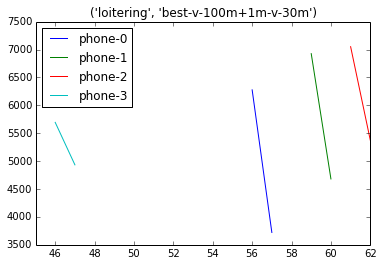

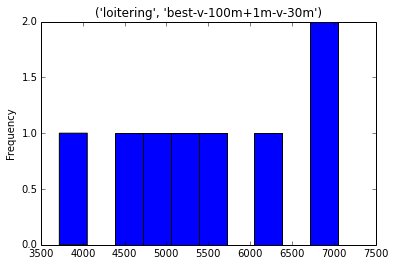

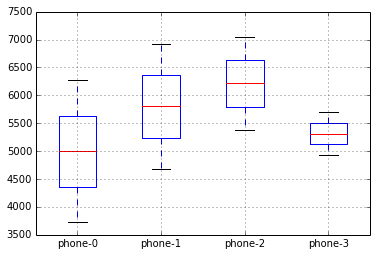

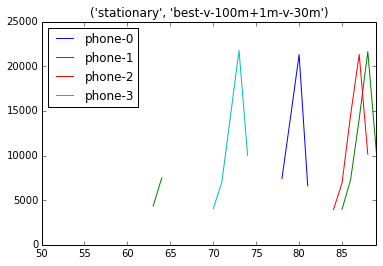

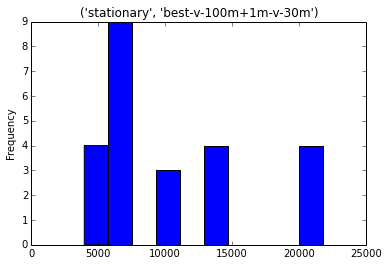

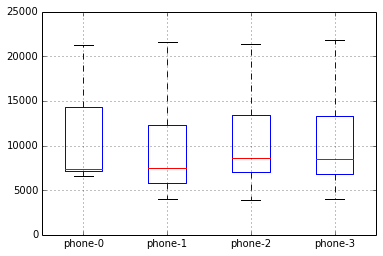

In [54]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[1] == 'high-v-balanced+1sec-v-15sec':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(android_battery_df, df)
        time_diff_series_list = map(lambda rl: map(lambda df: df.ts.diff(), rl), combined_df_list)
        try:
            concat_df_list = map(lambda rl: pd.concat(rl), time_diff_series_list)
        except ValueError, e:
            print "No data to concatenate, skipping"
            continue
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
        
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        # filtered_df = concat_df_curr_regime.dropna()
        filtered_df = concat_df_curr_regime
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

For key ('charging-or-full', 'high-v-balanced+1sec-v-30sec', 'best-v-10m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
11  high-v-balanced+1sec-v-30sec  2016-04-01T10:05:28.890454-07:00   

          end_ts           ios_regime                    start_fmt_time  \
11  1.459530e+09  best-v-10m+1m-v-30m  2016-03-31T22:00:37.643000-07:00   

        start_ts             state  
11  1.459487e+09  charging-or-full   
lengths are [12]
lengths are [11]
lengths are [11]
lengths are [11]
         phone-0      phone-1      phone-2      phone-3
130          NaN          NaN          NaN          NaN
131          NaN          NaN          NaN  3598.018307
132          NaN          NaN          NaN  3605.664820
133          NaN          NaN          NaN  3603.170345
134          NaN          NaN          NaN  3593.039144
135          NaN          NaN  3604.978357  3591.142133
136          NaN          NaN  3602.223186  3606.272375
137          NaN      

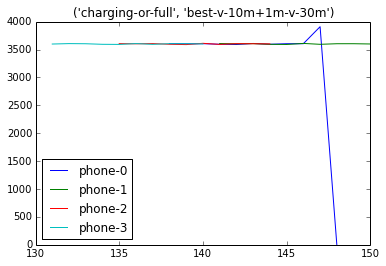

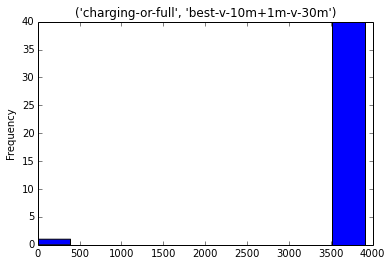

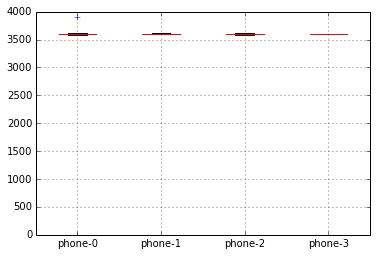

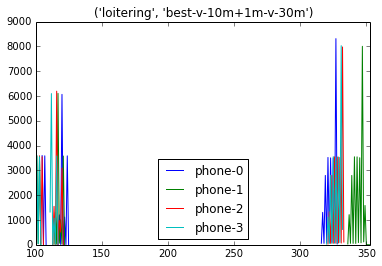

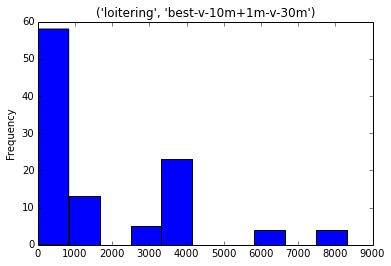

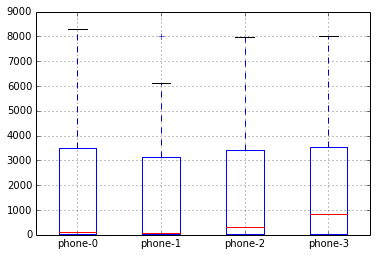

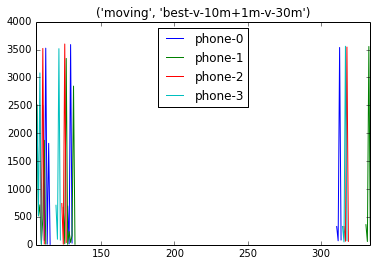

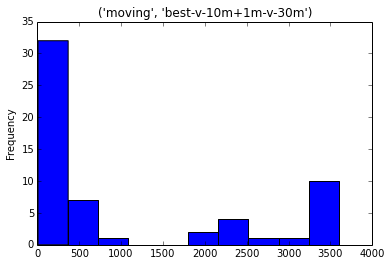

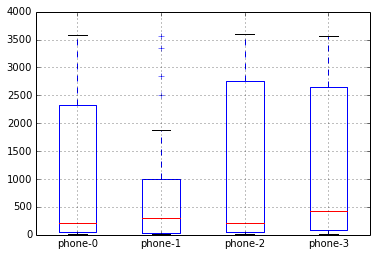

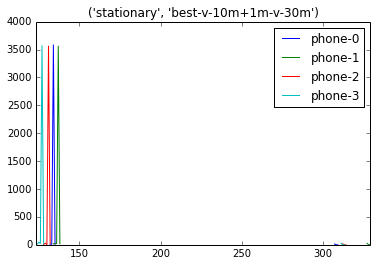

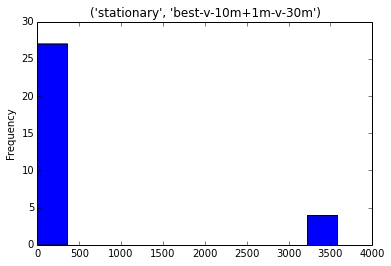

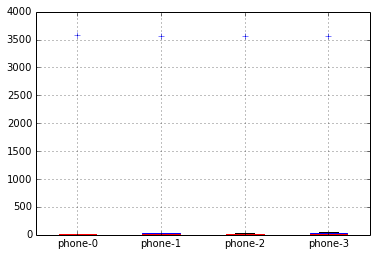

In [56]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[2] == 'best-v-10m+1m-v-30m' and key[0] != 'invalid':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(iphone_battery_df, df)
        time_diff_series_list = map(lambda rl: map(lambda df: df.ts.diff(), rl), combined_df_list)
        concat_df_list = map(lambda rl: pd.concat(rl), time_diff_series_list)
        
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
            
        print concat_df_curr_regime
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        # filtered_df = concat_df_curr_regime.dropna()
        filtered_df = concat_df_curr_regime
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        print "after filtering, length = %s" % len(filtered_df)
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

For key ('charging-or-full', 'high-v-balanced+1sec-v-30sec', 'best-v-10m+1m-v-30m'), ranges_df                   android_regime                      end_fmt_time  \
11  high-v-balanced+1sec-v-30sec  2016-04-01T10:05:28.890454-07:00   

          end_ts           ios_regime                    start_fmt_time  \
11  1.459530e+09  best-v-10m+1m-v-30m  2016-03-31T22:00:37.643000-07:00   

        start_ts             state  
11  1.459487e+09  charging-or-full   
lengths are [8]
lengths are [8]
lengths are [8]
lengths are [8]
         phone-0      phone-1      phone-2      phone-3
123          NaN          NaN          NaN          NaN
124          NaN          NaN          NaN    11.386458
125          NaN          NaN          NaN    43.786847
126          NaN          NaN          NaN    25.479548
127          NaN          NaN          NaN  3568.738424
128          NaN          NaN     6.513313    16.119860
129          NaN          NaN    29.379990          NaN
130          NaN          

-c:28: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


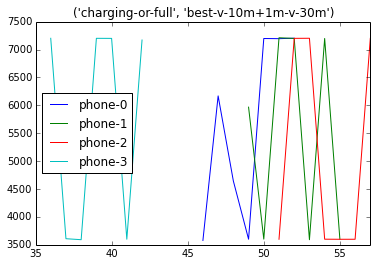

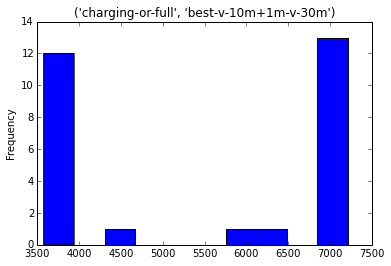

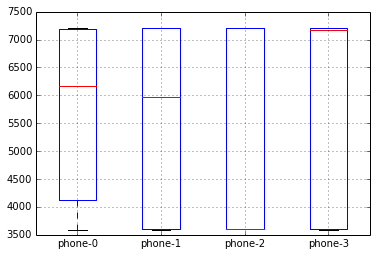

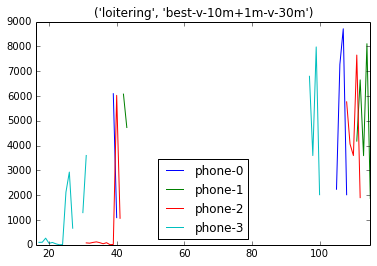

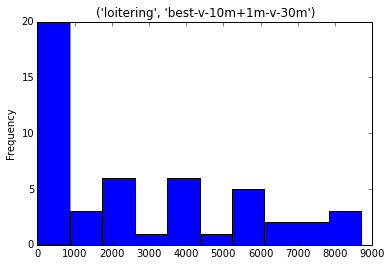

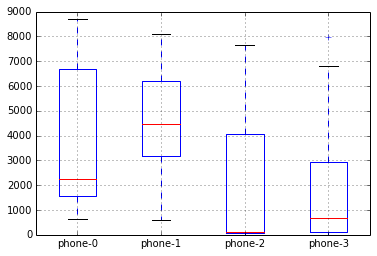

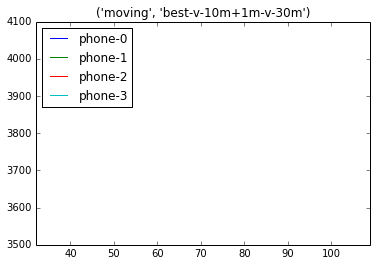

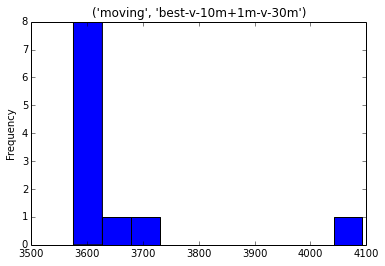

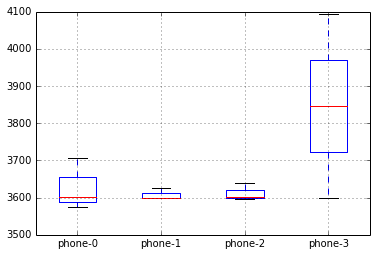

In [57]:
for key, df in filtered_regime_grouped_ranges_df:
    if key[1] == 'high-v-balanced+1sec-v-30sec' and key[0] != 'invalid':
        print "For key %s, ranges_df %s " % (key, df)
        combined_df_list = get_combined_df_list(android_battery_df, df)
        time_diff_series_list = map(lambda rl: map(lambda df: df.ts.diff(), rl), combined_df_list)
        try:
            concat_df_list = map(lambda rl: pd.concat(rl), time_diff_series_list)
        except ValueError, e:
            print "Skipping because no data for at least one phone"
            continue
        
        concat_df_dict = {}
        for i, df in enumerate(concat_df_list):
            concat_df_dict['phone-%s' % i] = df
            
        print concat_df_curr_regime
        concat_df_curr_regime = pd.DataFrame(concat_df_dict)
        # filtered_df = concat_df_curr_regime.dropna()
        filtered_df = concat_df_curr_regime
        all_phones_curr_regime_series = pd.concat(concat_df_list)
        ios_high_rates[key[0]] = all_phones_curr_regime_series
        print "after filtering, length = %s" % len(filtered_df)
        if len(filtered_df) > 0:
            filtered_df.plot(title=(key[0], key[2]))
            plt.figure()
            all_phones_curr_regime_series.plot(kind='hist', title=(key[0], key[2]))
            plt.figure()
            concat_df_curr_regime.boxplot()

In [58]:
import statsmodels.api as sm

In [59]:
ios_high_rates['moving'].shape, ios_high_rates['stationary'].shape

((22,), (39,))

In [143]:
def get_combined_df(sensor_df, ranges_df):
    combined_df_parts = map(lambda row: sensor_df[(sensor_df.metadata_write_ts >= row[1].start_ts) & (sensor_df.metadata_write_ts <= row[1].end_ts)],
                                                  ranges_df.iterrows())
    print "lengths are %s" % map(lambda dfp: np.count_nonzero(pd.notnull(dfp.battery_level_pct)), combined_df_parts)
    return filter(lambda dfp: np.count_nonzero(pd.notnull(dfp.battery_level_pct)) > 1, combined_df_parts)

In [144]:
def get_accuracy(regime, phone):
    if regime == "high+1sec":
        return "high-1"
    elif regime == "best+1m":
        return "best"
    elif regime == "high-v-balanced+1sec-v-30sec":
        if phone == 1:
            return "balanced-1"
        elif phone == 2:
            return "high-30"
        elif phone == 3:
            return "balanced-30"
    elif regime == "best-v-10m+1m-v-30m":
        if phone == 1:
            return "10m"
        elif phone == 2:
            return "best"
        elif phone == 3:
            return "10m"
    elif regime == "high-v-balanced+1sec-v-15sec":
        if phone == 1:
            return "balanced-1"
        elif phone == 2:
            return "high-15"
        elif phone == 3:
            return "balanced-15"
    elif regime == "best-v-100m+1m-v-30m":
        if phone == 1:
            return "100m"
        elif phone == 2:
            return "best"
        elif phone == 3:
            return "100m"    
    return "unknown"

In [145]:
all_accuracy_distance_series = {}
for acc in ["high-1", "balanced-1", "high-15", "balanced-15", "high-30", "balanced-30", "best", "10m", "100m"]:
    all_accuracy_distance_series[acc] =[]

In [146]:
def get_battery_levels(battery_df, row):
      return battery_df[(battery_df.ts >= row['start_ts']) & (battery_df.ts <= row['end_ts'])]

In [147]:
def is_valid_row(row):
    retVal =  row['state'] != 'charging' and row['state'] != 'charging-or-full' and row['state'] != 'invalid' and row['ios_regime'] != 'tracking-off' and row['android_regime'] != 'tracking-off'
    return retVal

In [148]:
for row in filtered_ranges_df.to_dict('records'):
    if is_valid_row(row):
        print "Reading entries for row %s "% row
        if row['android_regime'] != 'high-vs-balanced-vs-none+1sec-vs-30sec':
            for phone in range(1,4):
                all_accuracy_distance_series[get_accuracy(row['ios_regime'], phone)].append(
                    get_battery_levels(iphone_battery_interp_df[phone], row).battery_level_pct.diff())
                all_accuracy_distance_series[get_accuracy(row['android_regime'], phone)].append(
                    get_battery_levels(android_battery_interp_df[phone], row).battery_level_pct.diff())
        else:
            print "new regime, ignoring"
    else:
        print "Skipping row %s" % row

Reading entries for row {'ios_regime': 'best+1m', 'end_ts': 1459288014.9160001, 'start_ts': 1459279034.7, 'start_fmt_time': '2016-03-29T12:17:14.700000-07:00', 'android_regime': 'high+1sec', 'state': 'moving', 'end_fmt_time': '2016-03-29T14:46:54.916000-07:00'} 
Reading entries for row {'ios_regime': 'best+1m', 'end_ts': 1459301430.685, 'start_ts': 1459288014.9160001, 'start_fmt_time': '2016-03-29T14:46:54.916000-07:00', 'android_regime': 'high+1sec', 'state': 'loitering', 'end_fmt_time': '2016-03-29T18:30:30.685000-07:00'} 
Reading entries for row {'ios_regime': 'best+1m', 'end_ts': 1459302150.685, 'start_ts': 1459301430.685, 'start_fmt_time': '2016-03-29T18:30:54.916000-07:00', 'android_regime': 'high+1sec', 'state': 'moving', 'end_fmt_time': '2016-03-29T18:42:30.685000-07:00'} 
Reading entries for row {'ios_regime': 'best+1m', 'end_ts': 1459310790.275, 'start_ts': 1459302150.685, 'start_fmt_time': '2016-03-29T18:42:30.685000-07:00', 'android_regime': 'high+1sec', 'state': 'moving', 

In [193]:
balanced30list = .tolist()
balanced15list = .tolist()
print len(balanced30list), len(balanced15list)
print balanced30list[0:10]

86 134
[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.93001047140106152, nan]


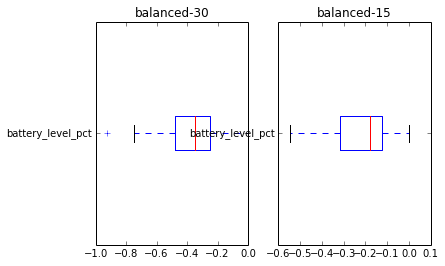

In [209]:
(fig, axes) = plt.subplots(nrows=1,ncols=2)
pd.concat(all_accuracy_distance_series['balanced-30']).plot.box(vert=False,ax=axes[0], title="balanced-30")
pd.concat(all_accuracy_distance_series['balanced-15']).plot.box(vert=False,ax=axes[1], title="balanced-15")

# pd.DataFrame({"a": [1,2,3], "b": [4,5,6,7]})

In [219]:
def compareState(accuracy_distance_series):
    mergedMedian = {}
    for accuracy in accuracy_distance_series:
        curr_accuracy_list = accuracy_distance_series[accuracy]
        curr_accuracy_merged = pd.concat(curr_accuracy_list)
        mergedMedian[accuracy] = curr_accuracy_merged.median()
    return pd.DataFrame({"power_drain_median": mergedMedian})

In [220]:
all_power_results = compareState(all_accuracy_distance_series)

In [221]:
all_power_results

,power_drain_median
100m,-0.505541
10m,-1.474259
balanced-1,-0.275815
balanced-15,-0.179558
balanced-30,-0.351745
best,-1.179192
high-1,-1.078690
high-15,-0.247349
high-30,-0.499910


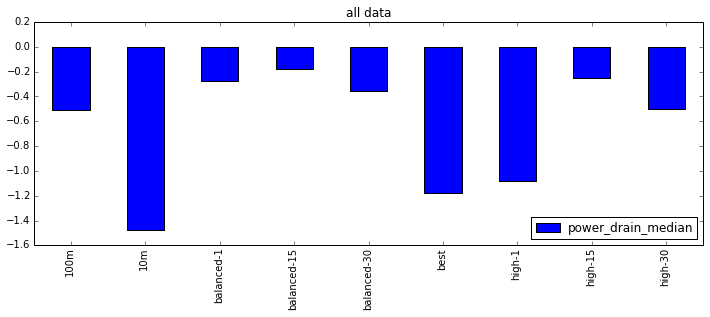

In [222]:
all_power_results.plot.bar(title="all data", figsize=(12,4))

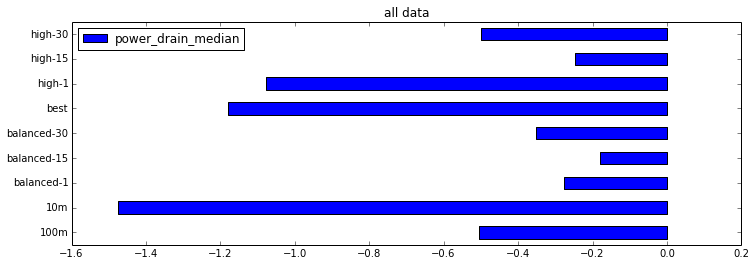

In [223]:
all_power_results.plot.barh(title="all data", figsize=(12,4))

In [226]:
all_power_results.to_csv(open("/tmp/power_results.csv", "w"))